Hello!

I´m so happy to share my results with you. I hope that all the included methods are clear, and if something is not clear, please tell me and I will explain you the what and why.

Let´s go.

As you emphasize in the test, one of the main things to achieve is the comfort of the cardiologist with the software. I have tried to approximate the project as much as possible, dividing the project into:

1. Selection of patient records that take into account whether they are duplicated or not, the probability of having a pathology or not, and whether they have been subsequently reviewed by a cardiologist and not just with the automatically produced label.
      - Patients who have a confidence level in their pathology with a higher score greater than 70% if they have been reviewed by a cardiologist, and greater than 85% if not (depending on the result offered by the automatic machine) have been selected.
      - The records of the duplicate patients have been left, since it is considered that this will not significantly influence the results, in addition to considering the possible recovery of the patient, providing future healthy labels, and with it, the sick-healthy transition, or vice versa.

2. Selection of the signals between 100 or 500 Hz of test frequency, selection of derivations, preprocessing and tuning to include in algorithms.
      - The 100 Hz signals have been selected, since according to https://www.mdpi.com/2073-8994/13/8/1461 , the optimum minimum frequency is 90 Hz so that distortion does not occur in the Q and S waves, which makes this frequency optimal to apply directly to acquisition devices in real time, and thus free up computing capacity, which is why it seems appropriate to test with this capture frequency, since it is possible to would approach the real environment of Idoven.
      - The signals have been normalized with respect to the training set, and subsequently filtered between 5 and 30 Hz with a 2nd order bandpass FIR butterwoth filter, since according to that there are no changes in the R-R waves, and a Nocth at 50 Hz.
      - The detection of the QRS complexes has been done through the following steps:
          - Filtering of the signal between 5 and 15 Hz, to keep the peaks of the beats.
          - Function np.squeeze() on the resulting signal to see all peaks in positive values
          - Convolution of pulses with the signal, thus providing a final matrix with "mountains" indicating the QRS complexes.
          - Implementation of scipy.signal.find_peaks(), with the distance parameter set to 10*fs, taken from https://www.samproell.io/posts/signal/peak-finding-python-js/. Considering that the R-R interval is between 1 beat per second under normal conditions, the minimum distance parameter to consider has been set as 100 points (100 points = 1 second).
          - Rejection of the possible false peaks detected, creating a condition that rejects those peaks that are above or below +-30% of the average of the R peaks.

3. Selection of the different algorithms proposed and comparison of results between them.
First, it has been narrowed down to 5 diseases according to https://arxiv.org/pdf/2004.13701v1.pdf.
      - ECGNET, whose architecture is available at https://ieeexplore.ieee.org/document/8438739.
          - The train, val and test sets have been separated as they come in the dataframe (without the observations removed in the previous steps).
      - TabPFN, a new one-step algorithm, which works very well a priori in few samples, whose training lasts less than 1 second, and manages to achieve equal or better metrics than xgboost https://www.automl.org/tabpfn -a-transformer-that-solves-small-tabular-classification-problems-in-a-second/
          - The beats of each derivation with the previously defined function have been selected, and it has been iterated over these for the extraction of characteristics:
              - Features taken from https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/algorithmfunctioning.html#calculation-of-measures.
              - Characteristics in frequency.
              - Features based on wavelets.
              - Merge with the metadata that comes in the database
          - 100 patients have been selected for each disease, thus obtaining a df of 600 rows.
          - Then it has been evaluated in 100 patients of each disease. It has not been older for a matter of time!
        

4. Creation of an interface, where the file to be loaded (ECG) is chosen, and the signals are displayed interactively, where you can choose whether to represent the first 6 leads or the last 6. On the right side, there is the option to choose the beat and get the average beat of the selected lead. Attached video to see it better!

---------------------------------

Things I would have liked to do if I had more time:
- Comparison of ECGNET with fewer leads (thus simulating a holter).
- Comparison of ECGNET with the signals interpolated to higher frequencies (for higher resolution) from the 100hz signals (to simulate obtaining signals from a holter with a low fs)
- It would be very interesting to develop a TabPFN model for each main class, trying to distinguish between the different subclasses, since when doing it on the 5 main classes, the variance is much higher.
- Create an algorithm that was able to predict the remaining leads (for example, from V1 to V6) from 1-3.
- Compare the differences between using the signals with 100 hz and with 500 hz in ECGNET.


----------------------------------
Conclusions:
- The derivations seem to have enough information in themselves to develop deep learning algorithms without the need to introduce external variables, which is why it is very helpful when it comes to obtaining predictions.
- The TabPFN algorithm does not seem to be adequate to discriminate between the 5 main types of disease, so it would require a more discriminative algorithm between the subclasses.
- The method used to detect R peaks varies depending on the derivation, since said peak can be very positive or very negative, depending on the derivation.
- The type and order of the filter and the cut-off frequencies are very important when implementing the algorithms, the function of searching for peaks, and for the visual analysis by the cardiologist.


-------------------------------
**Bibliography:**
Choose Fs: https://www.mdpi.com/2073-8994/13/8/1461 

Filter parameters: https://www.researchgate.net/publication/

Detección de picos: https://www.researchgate.net/publication/
307615951_Selection_of_Parameters_of_Bandpass_Filtering_of_the_ECG_Signal_for_Heart_Rhythm_Monitoring_Systems 

Distancia de latidos en find_peaks: https://www.samproell.io/posts/signal/peak-finding-python-js/

Agrupación de enfermedades: https://arxiv.org/pdf/2004.13701v1.pdf

ECGNET: https://ieeexplore.ieee.org/document/8438739

TabPFN: https://www.automl.org/tabpfn-a-transformer-that-solves-small-tabular-classification-problems-in-a-second/

Features: https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/algorithmfunctioning.html#calculation-of-measures


# Imports

In [5]:
import pandas as pd
import scipy.signal as ss
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.io import loadmat
import json
from typing import Tuple
import wfdb, ast
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import numpy as np
from scipy.signal import welch
from scipy.integrate import simps
from mne.time_frequency import psd_array_multitaper

# Functions

In [2]:
def apply_scaler(inputs: np.array, scaler: StandardScaler) -> np.array:
    """Applies standardization to each individual ECG signal.
    Parameters
    ----------
    inputs: np.array
        Array of ECG signals.
    scaler: StandardScaler
        Standard scaler object.
    Returns
    -------
    np.array
        Array of standardized ECG signals.
    """

    temp = []
    for x in inputs:
        x_shape = x.shape
        temp.append(scaler.transform(x.flatten()[:, np.newaxis]).reshape(x_shape))
    temp = np.array(temp)
    return temp





def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=False,n_jobs = -1)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


def get_relative_power(senal, f_low, f_high,fs ):
    fs = fs

    f, Px  = ss.welch(senal, fs=fs, window='hamming',nperseg=1024)
    #f, Px  = ss.welch(senal, fs=fs, window='hamming',nperseg=50,nfft=256)
    #f, Px  = ss.welch(senal, fs=fs)
    
    width = np.diff(f)
    
    #cojo todas las alturas menos la última, para que no chille por las dimensiones.
    pvec_total = np.multiply(width,Px[0:-1])
    avgp_total = np.sum(pvec_total);   
    
    #Puntos del vector de frecuencias que se corresponden con las frecuencias de corte
    f_low_index = (np.abs(f-f_low)).argmin()    
    f_high_index = (np.abs(f-f_high)).argmin()  

    #Calculo la integral entre esas dos frecuncias, se donde empieza y donde acaba.
    pvec = np.multiply(width[f_low_index:f_high_index], Px[f_low_index:f_high_index])
    avgp = np.sum(pvec);     # POTENCIA EN LA BANDA ELEGIDA
    
    #Ratio
    r_seg = avgp/avgp_total;  
    
    return r_seg #[r_seg,f]


    
def get_ratios(senal, fs, band_1, band_2):
    fs = fs

    if band_1 == "delta":
        f_low, f_high = 0.5, 4
    elif band_1 == "theta":
        f_low, f_high = 4, 8
    elif band_1 == "alpha":
        f_low, f_high = 8, 12
    elif band_1 == "beta":
        f_low, f_high = 12, 30
    elif band_1 == "gamma":
        f_low, f_high = 30, 50
    
    if band_2 == "delta":
        f_low_2, f_high_2 = 0.5, 4
    elif band_2 == "theta":
        f_low_2, f_high_2 = 4, 8
    elif band_2 == "alpha":
        f_low_2, f_high_2 = 8, 12
    elif band_2 == "beta":
        f_low_2, f_high_2 = 12, 30
    elif band_2 == "gamma":
        f_low_2, f_high_2 = 30, 60

    f, Px  = ss.welch(senal, fs=fs, window='hamming',nperseg=1024)
    #f, Px  = ss.welch(senal, fs=fs, window='hamming',nperseg=50,nfft=256)
    #f, Px  = ss.welch(senal, fs=fs, nperseg=50 )
    
    width = np.diff(f)

    #Puntos del vector de frecuencias que se corresponden con las frecuencias de corte con la banda elegida 1
    f_low_index_1 = (np.abs(f-f_low)).argmin()    
    f_high_index_1 = (np.abs(f-f_high)).argmin()  

    #Puntos del vector de frecuencias que se corresponden con las frecuencias de corte con la banda elegida 2
    f_low_index_2 = (np.abs(f-f_low_2)).argmin()    
    f_high_index_2 = (np.abs(f-f_high_2)).argmin()  


    # Calculo la integral de la banda 1
    pvec_1 = np.multiply(width[f_low_index_1:f_high_index_1], Px[f_low_index_1:f_high_index_1])
    ratio_1 = np.sum(pvec_1)     # POTENCIA EN LA BANDA ELEGIDA
    
    # Calculo la integral de la banda 2
    pvec_2 = np.multiply(width[f_low_index_2:f_high_index_2], Px[f_low_index_2:f_high_index_2])
    ratio_2 = np.sum(pvec_2)
    

    #Ratio
    r_seg = ratio_1/ratio_2
    
    return r_seg


def get_ratios(senal, fs, band_1, band_2):
    fs = fs

    if band_1 == "delta":
        f_low, f_high = 0.5, 4
    elif band_1 == "theta":
        f_low, f_high = 4, 8
    elif band_1 == "alpha":
        f_low, f_high = 8, 12
    elif band_1 == "beta":
        f_low, f_high = 12, 30
    elif band_1 == "gamma":
        f_low, f_high = 30, 50
    
    if band_2 == "delta":
        f_low_2, f_high_2 = 0.5, 4
    elif band_2 == "theta":
        f_low_2, f_high_2 = 4, 8
    elif band_2 == "alpha":
        f_low_2, f_high_2 = 8, 12
    elif band_2 == "beta":
        f_low_2, f_high_2 = 12, 30
    elif band_2 == "gamma":
        f_low_2, f_high_2 = 30, 60

    #f, Px  = ss.welch(senal, fs=fs, window='hamming',nperseg=1024)
    #f, Px  = ss.welch(senal, fs=fs, nperseg=50 )
    psd, freqs = psd_array_multitaper(senal, fs, adaptive=True)
    
    
    low1, high1 = f_low, f_high
    low2, high2 = f_low_2, f_high_2
    
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band1 = np.logical_and(freqs >= low1, freqs <= high1)
    idx_band2 = np.logical_and(freqs >= low2, freqs <= high2)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp1 = simps(psd[idx_band1], dx=freq_res)
    bp2 = simps(psd[idx_band2], dx=freq_res)
    
    return bp1/bp2


def find_qrs(ecg,name, seconds):

  def BandPassECG(ecg,Fs):
    '''
    This function takes in a "path" and Sampling Freq (Fs) imports the ECG signal in .mat format
    '''
    # Import the signal
    ECG    = ecg #wfdb.rdsamp(Path)[0]
    # Implementing the Butterworth BP filter
    W1     = 5*2/Fs       #0.5                              # --> 5 Hz cutt-off (high-pass) and Normalize by Sample Rate
    W2     = 15*2/Fs                                   # --> 15 Hz cutt-off (low-pass) and Normalize by Sample Rate
    b, a   = ss.butter(4, [W1,W2], 'bandpass')     # --> create b,a coefficients , since this is IIR we need both b and a coefficients
    ECG    = np.asarray(ECG)                           # --> let's convert the ECG to a numpy array, this makes it possible to perform vector operations 
    ECG_BP = ss.filtfilt(b,a,ECG)    # --> filtering: note we use a filtfilt that compensates for the delay
   # fig = plt.figure(figsize=(15,5),frameon="False")
   # plt.plot(ECG_BP)
    #plt.show()
    return ECG_BP,ECG

  def Differentiate(ECG):
    '''
    Compute single difference of the signal ECG
    '''
    ECG_df  = np.diff(ECG)
    ECG_sq  = np.power(ECG_df,2)
   # fig = plt.figure(figsize=(15,5),frameon="False")
   # plt.plot(ECG_sq)
   # plt.show()
    return np.insert(ECG_sq,0, ECG_sq[0])
  
  def MovingAverage(ECG,N=30):
    '''
    Compute moving average of signal ECG with a rectangular window of N
    '''
    window  = np.ones((1,N))/N
    ECG_ma  = np.convolve(np.squeeze(ECG),np.squeeze(window))
    return ECG_ma
  
  # Load and BP the Signal
  Fs = 100 #wfdb.rdsamp(Path)[1]["fs"]
  #Path = Path
  ECG_BP,ECG_raw = BandPassECG(ecg,Fs)
  
  
  # Create Series and plot the first 10 seconds
  ts_raw = pd.Series(np.squeeze(ECG_raw[:seconds*Fs] - np.mean(ECG_raw)), index=np.arange(ECG_raw[:seconds*Fs].shape[0])/Fs)
  ts_BP = pd.Series(np.squeeze(ECG_BP[:seconds*Fs]), index=np.arange(ECG_raw[:seconds*Fs].shape[0])/Fs)

  ECG_df = Differentiate(ECG_BP)
  ts_df = pd.Series(np.squeeze(ECG_df[:seconds*Fs]), index=np.arange(ECG_raw[:seconds*Fs].shape[0])/Fs)

  ECG_ma = MovingAverage(ECG_df)
  dif = len(np.squeeze(ECG_ma[:seconds*Fs])) - len(np.arange(ECG_raw[:seconds*Fs].shape[0])/Fs)
  ts_ma = pd.Series(np.squeeze(ECG_ma[:seconds*Fs]), index=np.arange(ECG_raw[:seconds*Fs].shape[0]+dif)/Fs)
 # fig = plt.figure(figsize=(15,5),frameon="False")
  #plt.plot(ECG_ma)
 # plt.show()

  def QRSpeaks(ECG,Fs):
    '''
    Finds peaks in a smoothed signal ECG and sampling freq Fs.
    '''
    peaks, _  = ss.find_peaks(ECG, height=np.mean(ECG), distance=round(Fs*0.4))
    #peaks = ss.find_peaks_cwt(ECG, widths=10)
    return peaks

  # DETECT PEAKS
  n1 = ['I', 'II', 'III', 'AVF']
  n2 = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'AVR', 'AVL']

  if name in n1:
    QRS_ = QRSpeaks(ECG_ma,Fs)
    #QRS = QRS_init[QRS_init<=10*Fs]
    QRS = list([list(ecg).index(np.max(ecg[i-35:i])) for i in QRS_[1:]])
    QRS.insert(0,list(ecg).index(np.max(ecg[0:QRS_[0]])))
    QRS = np.array(QRS)
    

    # REJECT FALSE PEAKS
    thresold = np.mean(ecg[QRS])
    interval_thresold = [thresold-thresold*0.3,thresold + thresold*0.3] 
    QRS_2 = []
    for i in ecg[QRS]:
        if i <= interval_thresold[0]  and i >= interval_thresold[1]:
            pass
        else:
            QRS_2.append(list(ecg).index(i))

    QRS = QRS_2
    return QRS 

  elif name in n2:
    QRS_ = QRSpeaks(ECG_ma,Fs)
    #QRS = QRS_init[QRS_init<=10*Fs]
    QRS = list([list(ecg).index(np.min(ecg[i-35:i])) for i in QRS_[1:]])
    QRS.insert(0,list(ecg).index(np.min(ecg[0:QRS_[0]])))
    QRS = np.array(QRS)
    

    # REJECT FALSE PEAKS
    thresold = np.mean(ecg[QRS])
    interval_thresold = [thresold-thresold*0.3,thresold + thresold*0.3] 
    QRS_2 = []
    for i in ecg[QRS]:
        if i >= interval_thresold[0]  and i <= interval_thresold[1]:
            pass
        else:
            QRS_2.append(list(ecg).index(i))
    QRS = QRS_2
    return QRS 
    

def butter_lowpass(cutoff, sample_rate, order=2):
    '''standard lowpass filter.

    Function that defines standard Butterworth lowpass filter

    Parameters
    ----------
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
        All frequencies above cutoff are filtered out.

    sample_rate : int or float
        sample rate of the supplied signal

    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency. Typically orders above 6
        are not used frequently.
        default: 2
    
    Returns
    -------
    out : tuple
        numerator and denominator (b, a) polynomials
        of the defined Butterworth IIR filter.

    Examples
    --------
    >>> b, a = butter_lowpass(cutoff = 2, sample_rate = 100, order = 2)
    >>> b, a = butter_lowpass(cutoff = 4.5, sample_rate = 12.5, order = 5)
    '''
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_highpass(cutoff, sample_rate, order=2):
    '''standard highpass filter.

    Function that defines standard Butterworth highpass filter

    Parameters
    ----------
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
        All frequencies below cutoff are filtered out.

    sample_rate : int or float
        sample rate of the supplied signal

    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency. Typically orders above 6
        are not used frequently.
        default : 2
    
    Returns
    -------
    out : tuple
        numerator and denominator (b, a) polynomials
        of the defined Butterworth IIR filter.

    Examples
    --------
    we can specify the cutoff and sample_rate as ints or floats.

    >>> b, a = butter_highpass(cutoff = 2, sample_rate = 100, order = 2)
    >>> b, a = butter_highpass(cutoff = 4.5, sample_rate = 12.5, order = 5)
    '''
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_bandpass(lowcut, highcut, sample_rate, order=2):
    '''standard bandpass filter.
    Function that defines standard Butterworth bandpass filter.
    Filters out frequencies outside the frequency range
    defined by [lowcut, highcut].

    Parameters
    ----------
    lowcut : int or float
        Lower frequency bound of the filter in Hz

    highcut : int or float
        Upper frequency bound of the filter in Hz

    sample_rate : int or float
        sample rate of the supplied signal

    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency. Typically orders above 6
        are not used frequently.
        default : 2
    
    Returns
    -------
    out : tuple
        numerator and denominator (b, a) polynomials
        of the defined Butterworth IIR filter.

    Examples
    --------
    we can specify lowcut, highcut and sample_rate as ints or floats.

    >>> b, a = butter_bandpass(lowcut = 1, highcut = 6, sample_rate = 100, order = 2)
    >>> b, a = butter_bandpass(lowcut = 0.4, highcut = 3.7, sample_rate = 72.6, order = 2)
    '''
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def filter_signal(data, cutoff, sample_rate, order=2, filtertype='lowpass',
                  return_top = False):
    '''Apply the specified filter

    Function that applies the specified lowpass, highpass or bandpass filter to
    the provided dataset.

    Parameters
    ----------
    data : 1-dimensional numpy array or list 
        Sequence containing the to be filtered data

    cutoff : int, float or tuple
        the cutoff frequency of the filter. Expects float for low and high types
        and for bandpass filter expects list or array of format [lower_bound, higher_bound]

    sample_rate : int or float
        the sample rate with which the passed data sequence was sampled

    order : int
        the filter order 
        default : 2

    filtertype : str
        The type of filter to use. Available:
        - lowpass : a lowpass butterworth filter
        - highpass : a highpass butterworth filter
        - bandpass : a bandpass butterworth filter
        - notch : a notch filter around specified frequency range
        both the highpass and notch filter are useful for removing baseline wander. The notch
        filter is especially useful for removing baseling wander in ECG signals.


    Returns
    -------
    out : 1d array
        1d array containing the filtered data

    Examples
    --------
    >>> import numpy as np
    >>> import heartpy as hp

    Using standard data provided

    >>> data, _ = hp.load_exampledata(0)

    We can filter the signal, for example with a lowpass cutting out all frequencies
    of 5Hz and greater (with a sloping frequency cutoff)

    >>> filtered = filter_signal(data, cutoff = 5, sample_rate = 100.0, order = 3, filtertype='lowpass')
    >>> print(np.around(filtered[0:6], 3))
    [530.175 517.893 505.768 494.002 482.789 472.315]

    Or we can cut out all frequencies below 0.75Hz with a highpass filter:

    >>> filtered = filter_signal(data, cutoff = 0.75, sample_rate = 100.0, order = 3, filtertype='highpass')
    >>> print(np.around(filtered[0:6], 3))
    [-17.975 -28.271 -38.609 -48.992 -58.422 -67.902]

    Or specify a range (here: 0.75 - 3.5Hz), outside of which all frequencies
    are cut out.

    >>> filtered = filter_signal(data, cutoff = [0.75, 3.5], sample_rate = 100.0, 
    ... order = 3, filtertype='bandpass')
    >>> print(np.around(filtered[0:6], 3))
    [-12.012 -23.159 -34.261 -45.12  -55.541 -65.336]

    A 'Notch' filtertype is also available (see remove_baseline_wander).
    
    >>> filtered = filter_signal(data, cutoff = 0.05, sample_rate = 100.0, filtertype='notch')

    Finally we can use the return_top flag to only return the filter response that
    has amplitute above zero. We're only interested in the peaks, and sometimes
    this can improve peak prediction:

    >>> filtered = filter_signal(data, cutoff = [0.75, 3.5], sample_rate = 100.0, 
    ... order = 3, filtertype='bandpass', return_top = True)
    >>> print(np.around(filtered[48:53], 3))
    [ 0.     0.     0.409 17.088 35.673]
    '''
    if filtertype.lower() == 'lowpass':
        b, a = butter_lowpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'highpass':
        b, a = butter_highpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'bandpass':
        assert type(cutoff) == tuple or list or np.array, 'if bandpass filter is specified, \
cutoff needs to be array or tuple specifying lower and upper bound: [lower, upper].'
        b, a = butter_bandpass(cutoff[0], cutoff[1], sample_rate, order=order)
    elif filtertype.lower() == 'notch':
        b, a = iirnotch(cutoff, Q = 0.005, fs = sample_rate)
    else:
        raise ValueError('filtertype: %s is unknown, available are: \
lowpass, highpass, bandpass, and notch' %filtertype)

    from scipy.signal import lfilter, sosfiltfilt
    filtered_data = filtfilt(b, a, data,padlen=27)
    
    if return_top:
        return np.clip(filtered_data, a_min = 0, a_max = None)
    else:
        return filtered_data


def smooth_signal(data, sample_rate, window_length=None, polyorder=3):
    
    '''smooths given signal using savitzky-golay filter

    Function that smooths data using savitzky-golay filter using default settings.

    Functionality requested by Eirik Svendsen. Added since 1.2.4

    Parameters
    ----------
    data : 1d array or list
        array or list containing the data to be filtered

    sample_rate : int or float
        the sample rate with which data is sampled

    window_length : int or None
        window length parameter for savitzky-golay filter, see Scipy.signal.savgol_filter docs.
        Must be odd, if an even int is given, one will be added to make it uneven.
        default : 0.1  * sample_rate

    polyorder : int
        the order of the polynomial fitted to the signal. See scipy.signal.savgol_filter docs.
        default : 3

    Returns
    -------
    smoothed : 1d array
        array containing the smoothed data

    Examples
    --------
    Given a fictional signal, a smoothed signal can be obtained by smooth_signal():

    >>> x = [1, 3, 4, 5, 6, 7, 5, 3, 1, 1]
    >>> smoothed = smooth_signal(x, sample_rate = 2, window_length=4, polyorder=2)
    >>> np.around(smoothed[0:4], 3)
    array([1.114, 2.743, 4.086, 5.   ])

    If you don't specify the window_length, it is computed to be 10% of the 
    sample rate (+1 if needed to make odd)
    >>> import heartpy as hp
    >>> data, timer = hp.load_exampledata(0)
    >>> smoothed = smooth_signal(data, sample_rate = 100)

    '''

    if window_length == None:
        window_length = sample_rate // 10
        
    if window_length % 2 == 0 or window_length == 0: window_length += 1

    smoothed = savgol_filter(data, window_length = window_length,
                             polyorder = polyorder)

    return smoothed


def preprocess(path: str = "data/ptb") -> Tuple[np.array]:
    """Preprocesses the dataset.
    Parameters
    ----------
    path: str
        Path to the dataset. (default: 'data/ptb')
    Returns
    -------
    tuple[np.array]
        Tuple of arrays containing train, valid and test data.
    """

    print("Loading dataset...", end="\n" * 2)

    path = os.path.join(os.getcwd(), Path(path))
    Y = df_clean  
    data = np.array([wfdb.rdsamp(os.path.join(path, f))[0] for f in Y.filename_lr])

    agg_df = pd.read_csv(os.path.join(path, "scp_statements.csv"), index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def agg(y_dic):
        y_dic = eval(y_dic)
        temp = []

        for key in y_dic.keys():
            if key in agg_df.index:
                c = agg_df.loc[key].diagnostic_class
                if str(c) != "nan":
                    temp.append(c)
        return list(set(temp))

    Y["scp_codes"] = Y.scp_codes.apply(agg)
    Y["superdiagnostic_len"] = Y["scp_codes"].apply(lambda x: len(x))
    counts = pd.Series(np.concatenate(Y.scp_codes.values)).value_counts()
    Y["scp_codes"] = Y["scp_codes"].apply(
        lambda x: list(set(x).intersection(set(counts.index.values)))
    )

    X_data = data[Y["superdiagnostic_len"] >= 1]
    Y_data = Y[Y["superdiagnostic_len"] >= 1]

    print("Preprocessing dataset...", end="\n" * 2)

    mlb = MultiLabelBinarizer()
    mlb.fit(Y_data["scp_codes"])
    y = mlb.transform(Y_data["scp_codes"].values)

    # Stratified split
    X_train = X_data[Y_data.strat_fold < 9]
    y_train = y[Y_data.strat_fold < 9]

    X_val = X_data[Y_data.strat_fold == 9]
    y_val = y[Y_data.strat_fold == 9]

    X_test = X_data[Y_data.strat_fold == 10]
    y_test = y[Y_data.strat_fold == 10]

    del X_data, Y_data, y, data

    # Standardization
    scaler = StandardScaler()
    scaler.fit(np.vstack(X_train).flatten()[:, np.newaxis].astype(float))
    X_train_scale = apply_scaler(X_train, scaler)
    X_test_scale = apply_scaler(X_test, scaler)
    X_val_scale = apply_scaler(X_val, scaler)

    del X_train, X_test, X_val

    # Shuffling
    X_train_scale, y_train = shuffle(X_train_scale, y_train, random_state=42)

    return X_train_scale, y_train, X_test_scale, y_test, X_val_scale, y_val


In [3]:
path = os.path.join(os.getcwd(), Path("D:\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2 (1)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2"))
Y = pd.read_csv(os.path.join(path, "ptbxl_database.csv"), index_col="ecg_id")
wfdb.rdsamp(os.path.join(path, Y.filename_lr.values[0]))[1]['sig_name']

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Constants

In [295]:
NORM = ['NORM']
STTC = ['NDT', 'NST_', 'DIG', 'LNGQT', 'ISC_', 'ISCAL', 'ISCIN', 'ISCIL', 'ISCAS', 'ISCLA', 'ANEUR', 'EL', 'ISCAN' ]
MI = ['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN', 'INJLA', 'PMI', 'INJIL']
HYP = ['LVH', 'LAO/LAE', 'RVH', 'RAO/RAE', 'SEHYP']
CD = ['LAFB', 'IRBBB', '1AVB', 'IVCD', 'CRBBB', 'CLBBB', 'LPFB', 'WPW', 'ILBBB', '3AVB','2AVB']
OTHER = ['AFLT', 'AFIB', 'PSVT', 'STACH', 'PVC', 'PACE', 'PAC'] 

path_data = "D:\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2 (1)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2"
path_signals = path_data + 'records500' # 500 for fs=500 Hz
metadata = path_data + '/ptbxl_database.csv'  # where the relevant data is
df_scp = pd.read_csv(path_data + "/scp_statements.csv")   # for explain the scp standard
os.listdir(path_data)

# 'ptbxl_v102_changelog.txt' not relevant for this case

['example_physionet.py',
 'LICENSE.txt',
 'ptbxl_database.csv',
 'ptbxl_v102_changelog.txt',
 'RECORDS',
 'records100',
 'records500',
 'scp_statements.csv',
 'SHA256SUMS.txt']

- scp_statements.csv : For illustration, we use diagnostic subclass statements as labels based on the assignments in scp_statements.csv

# Code

In [528]:
df = pd.read_csv(metadata)
df.shape, df.columns

((21801, 44),
 Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
        'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
        'infarction_stadium1', 'infarction_stadium2', 'validated_by',
        'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
        'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
        'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
        'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
        'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
        'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL'],
       dtype='object'))

In [529]:
len(df.patient_id.unique())

18869

In [530]:
df_filenames = df[['filename_lr', 'filename_hr']]
df_strat_fold = df[["strat_fold"]]    # tran val or test
df_general_metadata = df[["age", "sex", "height", "weight", "nurse", "site", "device" , "recording_date"]]
df_core = df[["scp_codes","report"]]
df_ecg_statments = df[["heart_axis", "infarction_stadium1", "infarction_stadium2", "validated_by", "second_opinion", "initial_autogenerated_report" , "validated_by_human"]]
df_signal_metadata = df[["static_noise" , "burst_noise", "baseline_drift", "electrodes_problems", "extra_beats", "pacemaker"]]
df_binary_var = df[['RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
        'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
        'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL']]

In [531]:
df.patient_id.duplicated().sum()

2932

**Remove patients**

There are several situations to consider:
- scp_codes is generated by a cardiologist or automatically, it can be checked at:
     - initial_autogenerated_report if it was generated automatically initially
     - validated_by_human, if it has been subsequently validated by a cardiologist

- scp_codes provides low enough confidences to consider discarding such observations

Therefore, we are going to eliminate the observations that:
- have less than 70% confidence in the disease with the highest score initially labeled or subsequently validated automatically by cardiologists
- those observations that have been initially generated automatically without further validation by a cardiologist, that have less than 85% confidence

In [532]:
print(df.validated_by_human.value_counts())
print(df.initial_autogenerated_report.value_counts())

True     16058
False     5743
Name: validated_by_human, dtype: int64
False    14988
True      6813
Name: initial_autogenerated_report, dtype: int64


In [533]:
patients_idx = []
patients_to_delete_idx = []
label = []
for index,row in df.iterrows():
    patient = int(row.patient_id)
    scp_dict = eval(row.scp_codes)  # from str to dict
    disease_max_value = max(scp_dict, key=scp_dict.get)
    max_value = scp_dict[disease_max_value]
    
    bin_auto = row.initial_autogenerated_report
    bin_val_by_human = row.validated_by_human

    # for labels by cardiologist
    if (bin_auto == False or bin_auto == True) and bin_val_by_human == True:
        if max_value >= 70:
            patients_idx.append(patient)
            label.append(disease_max_value)
        else:
            patients_to_delete_idx.append(patient)


    # for labels by auto and not posterior by cardiologist
    elif bin_auto == True and bin_val_by_human == False:
        if max_value >= 85:
            patients_idx.append(patient)
            label.append(disease_max_value)
        else:
            patients_to_delete_idx.append(patient)


In [534]:
len(patients_idx),len(patients_to_delete_idx)

(19352, 2449)

**Split in NORM, STTC, MI, HYP, CD and OTHER.**

The diseases are included in "Constants" at the first of the page.

In [303]:
label_split = []

for lab in label:
    if lab in NORM:
        label_split.append("NORM")
    elif lab in STTC:
        label_split.append("STTC")
    elif lab in MI:
        label_split.append("MI")
    elif lab in HYP:
        label_split.append("HYP")
    elif lab in CD:
        label_split.append("CD")
    elif lab in OTHER:
        label_split.append("OTHER")

([<matplotlib.patches.Wedge at 0x29eb5546c50>,
 [Text(0.22133807610807296, 1.0775014877320481, 'NORM'),
  Text(-1.0909662117955354, -0.14068661883952926, 'CD'),
  Text(-0.4352625240610804, -1.010221032818055, 'STTC'),
  Text(0.6088239913181576, -0.9161513781004907, 'MI'),
  Text(1.032387025604245, -0.37970650424244845, 'HYP'),
  Text(1.093843985500181, -0.11621245795989353, 'OTHER')],
 [Text(0.1207298596953125, 0.5877280842174807, '44%'),
  Text(-0.5950724791612011, -0.07673815573065232, '17%'),
  Text(-0.23741592221513474, -0.5510296542643935, '16%'),
  Text(0.3320858134462677, -0.4997189335093585, '16%'),
  Text(0.5631201957841335, -0.20711263867769913, '4%'),
  Text(0.5966421739091895, -0.06338861343266919, '3%')])

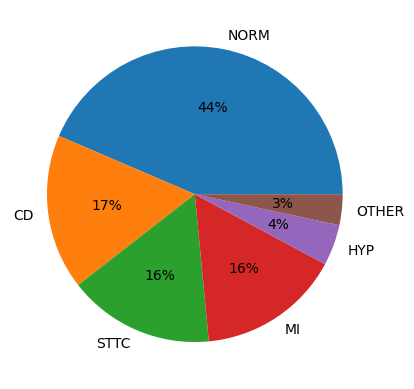

In [304]:
df_clean = df.loc[patients_idx]
df_clean.insert(0,"label",label_split)
name_labels = ["NORM", "CD", "STTC","MI", "HYP", "OTHER"]
plt.pie(df_clean.label.value_counts(), labels = name_labels,autopct='%.0f%%')

**Load the dataset**

We are going to apply the StandardScaler to each split (train, val and test), fitted on train.

In [67]:
X_train_scale, y_train, X_test_scale, y_test, X_val_scale, y_val = preprocess("D:/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2 (1)/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2")

Loading dataset...

Preprocessing dataset...



In [68]:
# filter the dataset normalized
from tqdm.auto import tqdm
X_train_scale_filt = np.ndarray(shape=(len(X_train_scale),1000,12))
for i in tqdm(range(len(X_train_scale))):
    derivations = X_train_scale[i].T
    #print(derivations)
    derivations_to_append = np.ndarray(shape=(1000,12))

    for j,signal in enumerate(derivations):
        s = filter_signal(signal,[0.6,40],100,4,"bandpass")
        X_train_scale_filt[i,:,j] = s

100%|██████████| 15182/15182 [03:32<00:00, 71.58it/s]


In [18]:
# before filter data by the confidence
X_train_scale.shape, X_test_scale.shape, X_val_scale.shape

((17090, 1000, 12), (2159, 1000, 12), (2147, 1000, 12))

In [69]:
# after clean df
X_train_scale.shape, X_test_scale.shape, X_val_scale.shape

((15182, 1000, 12), (1921, 1000, 12), (1871, 1000, 12))

#### View FFT

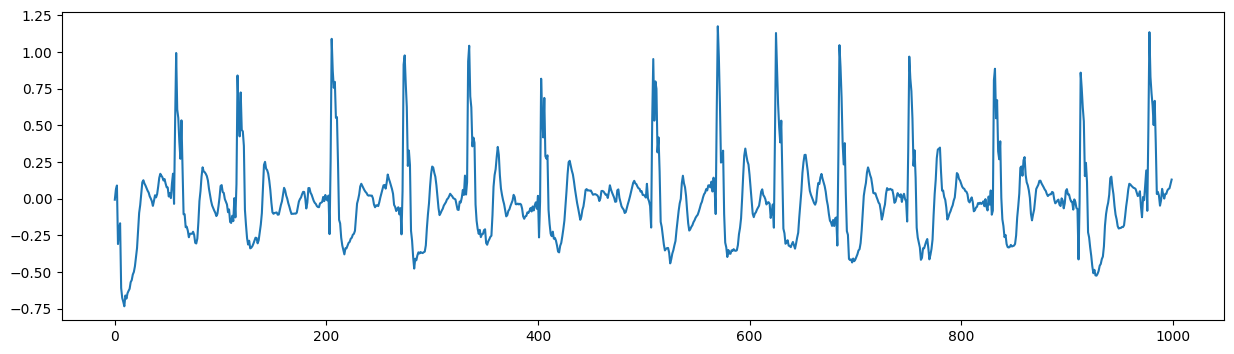

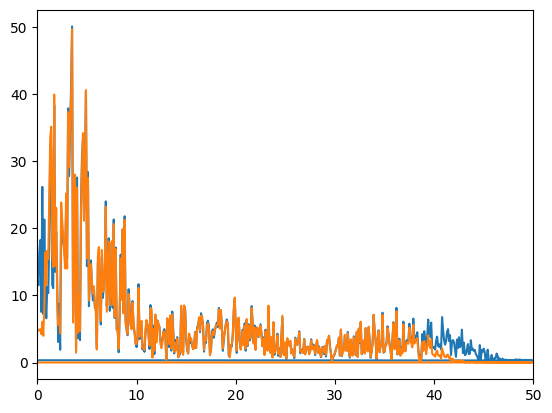

In [17]:
ecg = X_train_scale[0,:,1]

from scipy.fft import fft, fftfreq

#plt.plot(ecg)
ecg_bp = filter_signal(ecg,[5,30],100,order = 2, filtertype='bandpass')
ecg_notch = filter_signal(ecg_bp,50,100,order = 4, filtertype='notch')

plt.figure(figsize=(15,4))
plt.plot(ecg)
plt.plot(ecg_notch)
plt.show()


# Number of samples in normalized_tone
N = len(ecg)

yf = fft(ecg)
xf = fftfreq(N, 1 / 100)

yf_ = fft(list(base_remove))
xf_ = fftfreq(N, 1 / 100)


plt.plot(xf, np.abs(yf))
plt.plot(xf_, np.abs(yf_))
plt.xlim([0,50])
plt.show()

### Signals view and peak detection

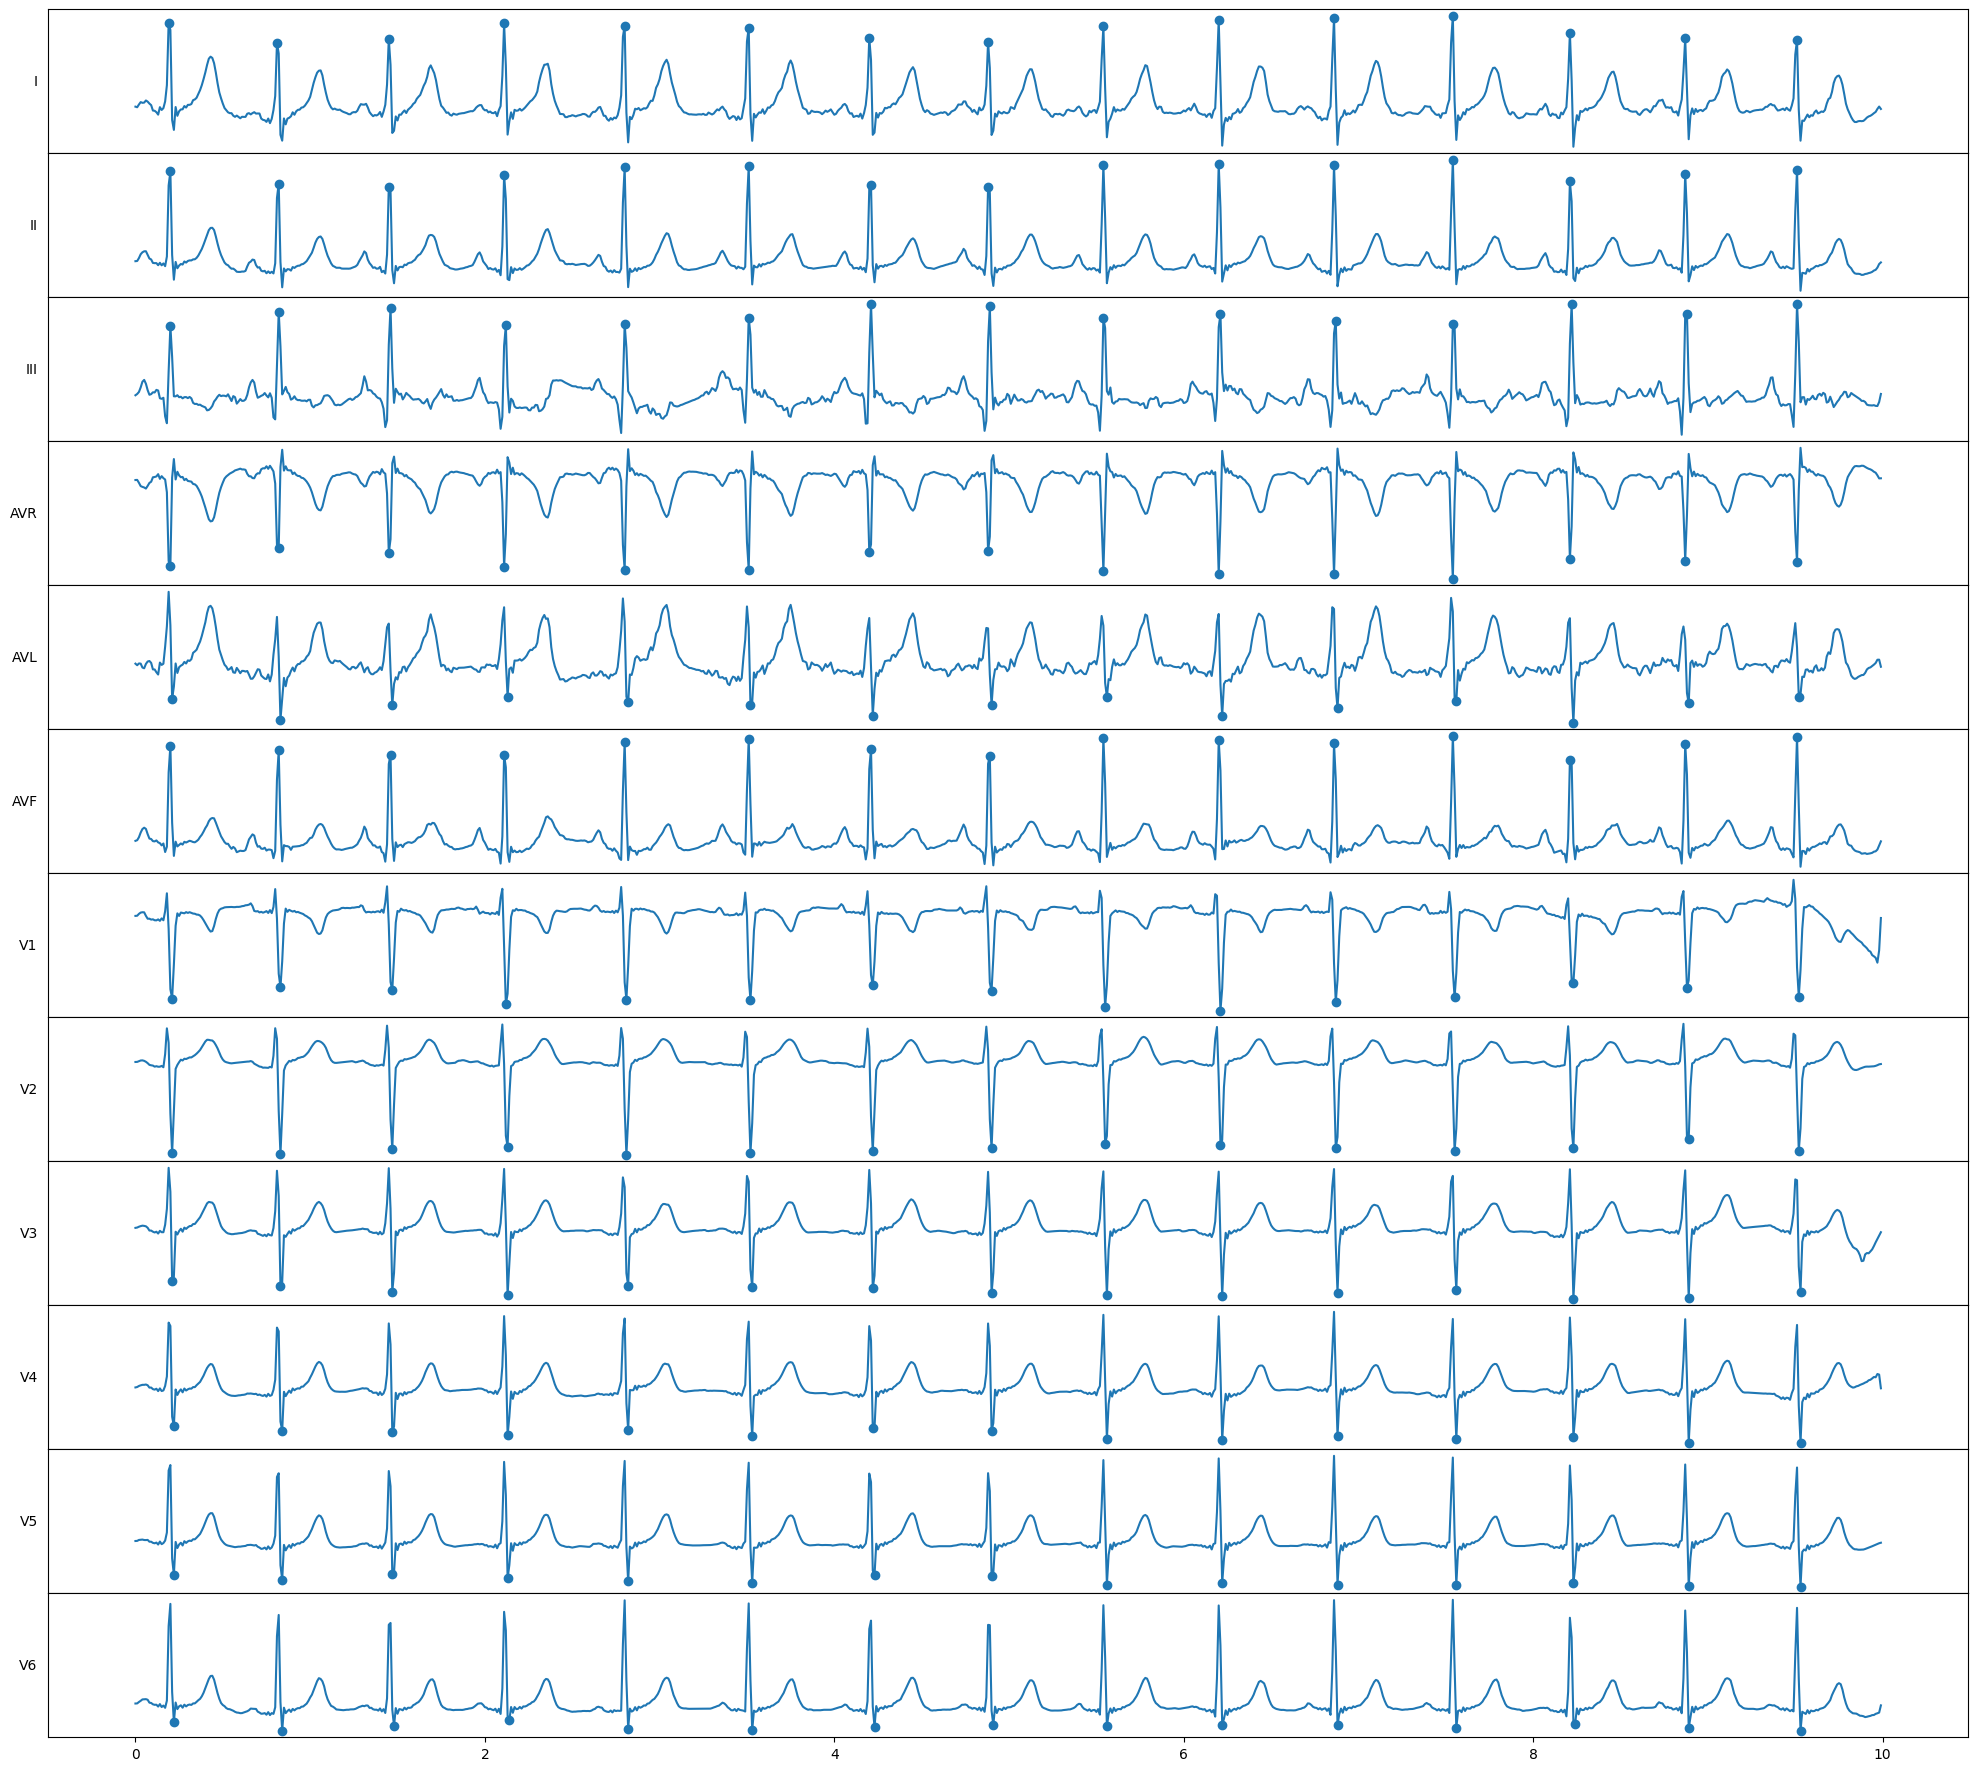

In [199]:
from pylab import figure, show, setp
fs=100
ecg_init = X_train_scale[1,:,:]
t = np.arange(0.0, len(ecg)/fs,1/fs)

fig = figure()

yprops = dict(rotation=0,
              horizontalalignment='right',
              verticalalignment='center',
              x=-0.01)

axprops = dict(yticks=[])

for index,signal in enumerate(names):
    ecg = ecg_init[:,index]
    ecg_bp = filter_signal(ecg,[0.6,40],100,order = 4, filtertype='bandpass')
    ecg_notch = filter_signal(ecg_bp,50,100,order = 4, filtertype='notch')

    qrs = find_qrs(ecg_notch,signal)

    ax1 =fig.add_axes([0.1, -index*0.3, 3, 0.3], **axprops)
    ax1.plot(t, ecg_notch)
    ax1.scatter(t[qrs],ecg_notch[qrs])
    ax1.set_ylabel(f'{signal}', **yprops)

    # turn off x ticklabels for all but the lower axes
   # for ax in ax1, ax2, ax3:
    setp(ax1.get_xticklabels(), visible=True)

show()

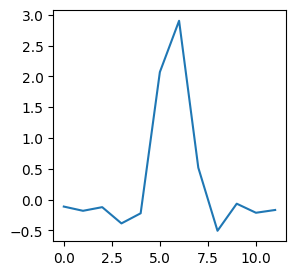

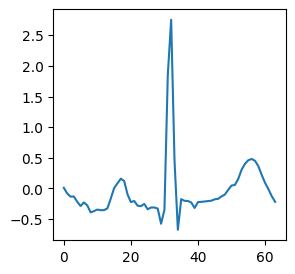

In [236]:
# duracion media del complejo QRS 0.12 s = 12 muestras
# duracion del latido P-T 0.64 s = 64 muestras

derivation = str(input())
index = names.index(derivation)

ecg = ecg_init[:,index]
ecg_bp = filter_signal(ecg,[0.6,40],100,order = 4, filtertype='bandpass')
ecg_notch = filter_signal(ecg_bp,50,100,order = 4, filtertype='notch')

qrs = find_qrs(ecg_notch,derivation)

COMPLEXES_QRS = [ecg_notch[c-6:c+6] for c in qrs]
PULSES = [ecg_notch[c-32:c+32] for c in qrs]

plt.figure(figsize=(3,3))
plt.plot(COMPLEXES_QRS[0])

plt.figure(figsize=(3,3))
plt.plot(PULSES[1])

### ALGORITHMS

In [467]:
# DATALOADER 

import math
from typing import Tuple

import numpy as np
import torch


class DataGen(torch.utils.data.Dataset):
    """Generates a torch Dataset object.
    Attributes
    ----------
    X: np.array
        Array of ECG signals.
    y: np.array
        Array of labels.
    batch_size: int, optional
        Batch size. (default: 32)
    """

    def __init__(self, X: np.array, y: np.array, batch_size: int = 32) -> None:
        self.batch_size = batch_size
        self.X = X
        self.y = y

    def __len__(self) -> int:
        return math.ceil(len(self.X) / self.batch_size)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]

        
        return torch.tensor(batch_x, dtype=torch.float32), torch.tensor(
            batch_y, dtype=torch.float32
        )

In [168]:
# METRICS

from typing import Tuple

import numpy as np
import warnings
from sklearn.metrics import roc_auc_score, accuracy_score


def Metrics(y_true: np.ndarray, y_scores: np.ndarray) -> Tuple[float, float]:
    """Metrics for class-wise accuracy and mean accuracy.
    Parameters
    ----------
    y_true : np.ndarray
        Ground truth labels.
    y_scores : np.ndarray
        Predicted labels.
    Returns
    -------
    tuple[np.ndarray]
        Tuple of arrays containing class-wise accuracy and mean accuracy.
    """

    y_pred = y_scores >= 0.5
    acc = np.zeros(y_pred.shape[-1])

    for i in range(y_pred.shape[-1]):
        acc[i] = accuracy_score(y_true[:, i], y_pred[:, i])

    return acc.tolist(), np.mean(acc)


def AUC(y_true: np.ndarray, y_pred: np.ndarray, verbose: bool = False) -> float:
    """Computes the macro-averaged AUC score.
    Parameters
    ----------
    y_true : np.ndarray
        Ground truth labels.
    y_scores : np.ndarray
        Predicted probabilities.
    Returns
    -------
    float
        macro-average AUC score.
    """

    aucs = []
    assert (
        len(y_true.shape) == 2 and len(y_pred.shape) == 2
    ), "Predictions and labels must be 2D."
    for col in range(y_true.shape[1]):
        try:
            aucs.append(roc_auc_score(y_true[:, col], y_pred[:, col]))
        except ValueError as e:
            if verbose:
                print(
                    f"Value error encountered for label {col}, likely due to using mixup or "
                    f"lack of full label presence. Setting AUC to accuracy. "
                    f"Original error was: {str(e)}."
                )
            aucs.append((y_pred == y_true).sum() / len(y_pred))
    return aucs


def multi_threshold_precision_recall(
    y_true: np.ndarray, y_pred: np.ndarray, thresholds: np.ndarray
) -> Tuple[float, float]:
    """Precision and recall for different thresholds.
    Parameters
    ----------
    y_true : np.ndarray
        Ground truth labels.
    y_scores : np.ndarray
        Predicted probabilities.
    thresholds : np.ndarray
        Thresholds to use for computing precision and recall.
    Returns
    -------
    Tuple[float, float]
       Average precision and recall.
    """

    # Expand analysis to number of thresholds
    y_pred_bin = (
        np.repeat(y_pred[None, :, :], len(thresholds), axis=0)
        >= thresholds[:, None, None]
    )
    y_true_bin = np.repeat(y_true[None, :, :], len(thresholds), axis=0)

    # Compute true positives
    TP = np.sum(np.logical_and(y_true, y_pred_bin), axis=2)

    # Compute macro-average precision handling all warnings
    with np.errstate(divide="ignore", invalid="ignore"):
        den = np.sum(y_pred_bin, axis=2)
        precision = TP / den
        precision[den == 0] = np.nan
        with warnings.catch_warnings():  # for nan slices
            warnings.simplefilter("ignore", category=RuntimeWarning)
            av_precision = np.nanmean(precision, axis=1)

    # Compute macro-average recall
    recall = TP / np.sum(y_true_bin, axis=2)
    av_recall = np.mean(recall, axis=1)

    return av_precision, av_recall


def metric_summary(
    y_true: np.ndarray, y_pred: np.ndarray, num_thresholds: int = 10
) -> Tuple[float]:
    """Metric summary for computing precision and recall at different thresholds. Also computes mean AUC and F1-scores
    Parameters
    ----------
    y_true : np.ndarray
        Ground truth labels.
    y_scores : np.ndarray
        Predicted probabilities.
    num_thresholds : int
        Number of thresholds to use for computing precision and recall.
    Returns
    -------
    tuple[float]
         Average precision, recall, F1-scores and AUC.
    """

    thresholds = np.arange(0.00, 1.01, 1.0 / (num_thresholds - 1), float)
    average_precisions, average_recalls = multi_threshold_precision_recall(
        y_true, y_pred, thresholds
    )
    f_scores = (
        2
        * (average_precisions * average_recalls)
        / (average_precisions + average_recalls)
    )
    auc = np.array(AUC(y_true, y_pred, verbose=True)).mean()
    return (
        f_scores[np.nanargmax(f_scores)],
        auc,
        f_scores.tolist(),
        average_precisions.tolist(),
        average_recalls.tolist(),
        thresholds.tolist(),
    )

In [169]:
from typing import Tuple
import os
import random
import argparse
import json
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn

#from preprocessing.preprocess import preprocess
#from utils.torch_dataloader import DataGen
#from utils.metrics import Metrics

# Random seed
seed = 42
random.seed(seed)
np.random.seed(seed)


def dump_logs(train_results: tuple, test_results: tuple, name: str):
    """Dumps the performance logs to a json file.
    Parameters
    ----------
    train_results: tuple
        Training results.
    test_results: tuple
        Testing results.
    name: str
        Name of the model.
    """

    logs = {
        "train_loss": train_results[0],
        "train_mean_accuracy": train_results[1],
        "train_roc_score": train_results[2],
        "test_loss": test_results[0],
        "test_mean_accuracy": test_results[1],
        "test_roc_score": test_results[2],
    }
    logs_path = os.path.join(os.getcwd(), "logs")
    os.makedirs(logs_path, exist_ok=True)

    with open(os.path.join(logs_path, f"{name}_train_logs.json"), "w") as json_file:
        json.dump(logs, json_file)


def train_epoch(
    model: nn.Module,
    optimizer: torch.optim,
    loss_func,
    dataset,
    epoch: int,
    device: torch.device,
    loggr: bool = False,
) -> Tuple[float, float, float]:
    """Training of the model for one epoch.
    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    optimizer: torch.optim
        Optimizer to be used.
    loss_func: torch.nn._Loss
        Loss function to be used.
    dataset: torch.utils.data.DataLoader
        Dataset to be used.
    epoch: int, optional
        The current epoch.
    device: torch.device
        Device to be used.
    loggr: bool, optional
        To log wandb metrics. (default: False)
    """

    model.train()

    pred_all = []
    loss_all = []
    gt_all = []

    for batch_step in tqdm(range(len(dataset)), desc="train"):
        batch_x, batch_y = dataset[batch_step]
        batch_x = batch_x.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        batch_y = batch_y.to(device)

        pred = model(batch_x)
        pred_all.append(pred.cpu().detach().numpy())
        loss = loss_func(pred, batch_y)
        loss_all.append(loss.cpu().detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        gt_all.extend(batch_y.cpu().detach().numpy())

    print(f"Epoch: {epoch}")
    print("Train loss: ", np.mean(loss_all), end="\n" * 2)

    pred_all = np.concatenate(pred_all, axis=0)
    _, mean_acc = Metrics(np.array(gt_all), pred_all)
    print(f"Train acc: {mean_acc}")
    roc_score = roc_auc_score(np.array(gt_all), pred_all, average="macro")
    print(f"Roc_score acc: {roc_score}")

    if loggr is not None:
        loggr.log({"train_mean_accuracy": mean_acc, "epoch": epoch})
        loggr.log({"train_roc_score": roc_score, "epoch": epoch})
        loggr.log({"train_loss": np.mean(loss_all), "epoch": epoch})

    return np.mean(loss_all), mean_acc, roc_score


def test_epoch(
    model: nn.Module,
    loss_func: torch.optim,
    dataset,
    epoch: int,
    device: torch.device,
    loggr: bool = False,
) -> Tuple[float, float, float]:
    """Testing of the model for one epoch.
    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    loss_func: torch.nn.BCEWithLogitsLoss
        Loss function to be used.
    dataset: torch.utils.data.DataLoader
        Dataset to be used.
    epoch: int, optional
        The current epoch.
    device: torch.device
        Device to be used.
    loggr: bool, optional
        To log wandb metrics. (default: False)
    """

    model.eval()

    pred_all = []
    loss_all = []
    gt_all = []

    for batch_step in tqdm(range(len(dataset)), desc="valid"):
        batch_x, batch_y = dataset[batch_step]
        batch_x = batch_x.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        batch_y = batch_y.to(device)

        pred = model(batch_x)
        pred_all.append(pred.cpu().detach().numpy())
        loss = loss_func(pred, batch_y)
        loss_all.append(loss.cpu().detach().numpy())
        gt_all.extend(batch_y.cpu().detach().numpy())

    print("Val loss: ", np.mean(loss_all))
    pred_all = np.concatenate(pred_all, axis=0)
    _, mean_acc = Metrics(np.array(gt_all), pred_all)
    print(f"Val acc: {mean_acc} ")
    roc_score = roc_auc_score(np.array(gt_all), pred_all, average="macro")

    if loggr is not None:
        loggr.log({"test_mean_accuracy": mean_acc, "epoch": epoch})
        loggr.log({"test_roc_score": roc_score, "epoch": epoch})
        loggr.log({"test_loss": np.mean(loss_all), "epoch": epoch})

    return np.mean(loss_all), mean_acc, roc_score


def train(
    model: nn.Module,
    path: str = "data/ptb",
    batch_size: int = 32,
    epochs: int = 60,
    loggr: bool = False,
    name: str = "ecgnet",
) -> None:
    """Data preprocessing and training of the model.
    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    path: str, optional
        Path to the directory containing the data. (default: 'data/ptb')
    batch_size: int, optional
        Batch size. (default: 32)
    epochs: int, optional
        Number of epochs. (default: 60)
    loggr: wandb, optional
        To log wandb metrics. (default: None)
    name: str, optional
        Name of the model. (default: 'ecgnet')
    """

    #X_train_scale, y_train, _, _, X_val_scale, y_val = X_train_scale, y_train, X_test_scale, y_test, X_val_scale, y_val  # preprocess(path=path)
    train_gen = DataGen(X_train_scale, y_train, batch_size=batch_size)
    val_gen = DataGen(X_val_scale, y_val, batch_size=batch_size)

    checkpoint_filepath = os.path.join(os.getcwd(), "checkpoints")
    os.makedirs(checkpoint_filepath, exist_ok=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #Distributed Training if for multiple GPUs 
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    elif torch.cuda.device_count() == 1 :
        print("You have a GPU on your system, Let's use it")
    else:
        print("You don't have any GPU available on your system, Let's use CPU")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = torch.nn.BCEWithLogitsLoss()

    best_score = 0.0
    for epoch in range(epochs):
        train_results = train_epoch(
            model, optimizer, loss_func, train_gen, epoch, device, loggr=loggr
        )
        test_results = test_epoch(model, loss_func, val_gen, epoch, device, loggr=loggr)

        if epoch > 5 and best_score < test_results[2]:
            save_path = "D:/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2 (1)/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2" + f"{name}_weights.pt"
            torch.save(model.state_dict(), save_path)
            #dump_logs(train_results, test_results, name)
    return model


In [174]:
from typing import List
import torch
import torch.nn as nn

from typing import Tuple
# ECGNET
class ResBlock(nn.Module):
    """A class used to build a Residual block.
    Attributes
    ----------
    in_channel: int
        The number of input channels.
    out_channel: int
        The number of output channels.
    kernel_size: int
        The size of the kernel for 1D-convolution.
    stride: int
        The stride for 1D-convolution.
    padding: int
        The padding for 1D-convolution.
    downsample: bool, optional
        If True, downsamples the input. (default: None)
    Methods
    -------
    forward(x)
        Calculates the output of the Residual block.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        downsample: bool = None,
    ) -> None:
        super(ResBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsample = downsample

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        if self.downsample is not None:
            out = self.maxpool(out)
            identity = self.downsample(x)
        out += identity

        return out


class ECGNet(nn.Module):
    """A class used to build ECGNet model.
    Attributes
    ----------
    struct: list, optional
        The list of kernel sizes for each layer. (default: [15, 17, 19, 21])
    planes: int, optional
        The number of output channels for each layer. (default: 16)
    num_classes: int, optional
        The number of ouput classes. (default: 5)
    Methods
    -------
    _make_layer(kernel_size, stride, block, padding)
        Builds the ECGNet architecture.
    forward(x)
        Calculates the output of the ECGNet model.
    """

    def __init__(
        self,
        struct: List[int] = [15, 17, 19, 21],
        in_channels: int = 12,
        fixed_kernel_size: int = 17,
        num_classes: int = 5,
    ) -> None:
        super(ECGNet, self).__init__()
        self.struct = struct
        self.planes = 16
        self.parallel_conv = nn.ModuleList()

        for _, kernel_size in enumerate(struct):
            sep_conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=self.planes,
                kernel_size=kernel_size,
                stride=1,
                padding=0,
                bias=False,
            )
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=self.planes,
            out_channels=self.planes,
            kernel_size=fixed_kernel_size,
            stride=2,
            padding=2,
            bias=False,
        )
        self.block = self._make_layer(
            kernel_size=fixed_kernel_size, stride=1, padding=8
        )
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=8, stride=8, padding=2)
        self.rnn = nn.LSTM(
            input_size=12, hidden_size=40, num_layers=1, bidirectional=False
        )
        self.fc = nn.Linear(in_features=168, out_features=num_classes)

    def _make_layer(
        self, kernel_size: int, stride: int, blocks: int = 15, padding: int = 0
    ) -> List[ResBlock]:
        """Builds the ECGNet architecture.
        Parameters
        ----------
        kernel_size: int
            The size of the kernel for 1D-convolution.
        stride: int
            The stride for 1D-convolution.
        blocks: int, optional
            The number of blocks in the layer. (default: 15)
        padding: int, optional
            The padding for 1D-convolution. (default: 0)
        Returns
        -------
        nn.Module
            The output layer of the ECGNet model.
        """

        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            if (i + 1) % 4 == 0:
                downsample = nn.Sequential(
                    nn.Conv1d(
                        in_channels=self.planes,
                        out_channels=self.planes + base_width,
                        kernel_size=1,
                        stride=1,
                        padding=0,
                        bias=False,
                    ),
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                )
                layers.append(
                    ResBlock(
                        in_channels=self.planes,
                        out_channels=self.planes + base_width,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        downsample=downsample,
                    )
                )
                self.planes += base_width
            elif (i + 1) % 2 == 0:
                downsample = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
                layers.append(
                    ResBlock(
                        in_channels=self.planes,
                        out_channels=self.planes,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        downsample=downsample,
                    )
                )
            else:
                downsample = None
                layers.append(
                    ResBlock(
                        in_channels=self.planes,
                        out_channels=self.planes,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        downsample=downsample,
                    )
                )

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out_sep = []

        for i in range(len(self.struct)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  # out => [b, 16, 9960]

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  # out => [b, 64, 10]
        out = out.reshape(out.shape[0], -1)  # out => [b, 640]

        _, (rnn_h, _) = self.rnn(x.permute(2, 0, 1))
        new_rnn_h = rnn_h[-1, :, :]  # rnn_h => [b, 40]
        new_out = torch.cat([out, new_rnn_h], dim=1)  # out => [b, 680]
        result = self.fc(new_out)  # out => [b, 20]

        return result

#### Train ECGNET

In [175]:
# ecgnet
model_ecgnet = train(
        model  = ECGNet(),
        path= "D:/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2 (1)/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2",
        batch_size=32 , #32
        epochs=15, #20
        loggr=None,
        name="ECGNET",
    )

You don't have any GPU available on your system, Let's use CPU


train: 100%|██████████| 475/475 [23:44<00:00,  3.00s/it]


Epoch: 0
Train loss:  0.3656962574155707

Train acc: 0.8325517059675931
Roc_score acc: 0.8583590920321379


valid: 100%|██████████| 59/59 [01:10<00:00,  1.19s/it]


Val loss:  0.34220693
Val acc: 0.852699091394976 


train: 100%|██████████| 475/475 [22:15<00:00,  2.81s/it]  


Epoch: 1
Train loss:  0.30608164150463907

Train acc: 0.8644710841786326
Roc_score acc: 0.9037714619730493


valid: 100%|██████████| 59/59 [00:45<00:00,  1.29it/s]


Val loss:  0.3170188
Val acc: 0.8601817210048102 


train: 100%|██████████| 475/475 [19:48<00:00,  2.50s/it]


Epoch: 2
Train loss:  0.28586772008946065

Train acc: 0.8751152680806218
Roc_score acc: 0.9167505733205346


valid: 100%|██████████| 59/59 [00:44<00:00,  1.33it/s]


Val loss:  0.31259492
Val acc: 0.8627471940138964 


train: 100%|██████████| 475/475 [19:28<00:00,  2.46s/it]


Epoch: 3
Train loss:  0.27449753519735837

Train acc: 0.880608615465683
Roc_score acc: 0.9235301449292763


valid: 100%|██████████| 59/59 [00:44<00:00,  1.33it/s]


Val loss:  0.30804902
Val acc: 0.8669160876536612 


train: 100%|██████████| 475/475 [19:26<00:00,  2.46s/it]


Epoch: 4
Train loss:  0.26453420419442025

Train acc: 0.8854828085891187
Roc_score acc: 0.929034589753509


valid: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s]


Val loss:  0.3076213
Val acc: 0.8665954035275254 


train: 100%|██████████| 475/475 [18:40<00:00,  2.36s/it]


Epoch: 5
Train loss:  0.2564379848618256

Train acc: 0.8896061125016468
Roc_score acc: 0.9334398214914474


valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s]


Val loss:  0.30951297
Val acc: 0.8668091929449492 


train: 100%|██████████| 475/475 [18:12<00:00,  2.30s/it]


Epoch: 6
Train loss:  0.24887530629572116

Train acc: 0.8938348043736004
Roc_score acc: 0.9372629828999036


valid: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s]


Val loss:  0.3119914
Val acc: 0.8700160342063068 


train: 100%|██████████| 475/475 [18:15<00:00,  2.31s/it]


Epoch: 7
Train loss:  0.24052456683234164

Train acc: 0.897483862468713
Roc_score acc: 0.9414357107228952


valid: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s]


Val loss:  0.32017735
Val acc: 0.8690539818278996 


train: 100%|██████████| 475/475 [18:27<00:00,  2.33s/it]


Epoch: 8
Train loss:  0.23463353310760698

Train acc: 0.9012514820181794
Roc_score acc: 0.9441117425721007


valid: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


Val loss:  0.31376526
Val acc: 0.8706574024585783 


train: 100%|██████████| 475/475 [18:17<00:00,  2.31s/it]


Epoch: 9
Train loss:  0.22798047175532893

Train acc: 0.9040179159531023
Roc_score acc: 0.9469774943863088


valid: 100%|██████████| 59/59 [00:39<00:00,  1.50it/s]


Val loss:  0.32299498
Val acc: 0.8717263495456974 


train: 100%|██████████| 475/475 [22:50<00:00,  2.89s/it]


Epoch: 10
Train loss:  0.2215199200887429

Train acc: 0.9065077064945329
Roc_score acc: 0.9500382160902555


valid: 100%|██████████| 59/59 [00:52<00:00,  1.11it/s]


Val loss:  0.32900932
Val acc: 0.8721539283805452 


train: 100%|██████████| 475/475 [23:48<00:00,  3.01s/it]


Epoch: 11
Train loss:  0.21323369424594077

Train acc: 0.9104861019628508
Roc_score acc: 0.9535502416763691


valid: 100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Val loss:  0.3370578
Val acc: 0.8706574024585784 


train: 100%|██████████| 475/475 [24:32<00:00,  3.10s/it]


Epoch: 12
Train loss:  0.20631492250844052

Train acc: 0.9129363720194966
Roc_score acc: 0.9565180754586009


valid: 100%|██████████| 59/59 [00:55<00:00,  1.07it/s]


Val loss:  0.33584616
Val acc: 0.8707642971672902 


train: 100%|██████████| 475/475 [24:46<00:00,  3.13s/it]


Epoch: 13
Train loss:  0.19934525193352448

Train acc: 0.9165195626399685
Roc_score acc: 0.9591794487355184


valid: 100%|██████████| 59/59 [00:42<00:00,  1.40it/s]


Val loss:  0.35239452
Val acc: 0.8661678246926776 


train: 100%|██████████| 475/475 [20:34<00:00,  2.60s/it]


Epoch: 14
Train loss:  0.19163048375593988

Train acc: 0.9205506520879989
Roc_score acc: 0.9622112589420218


valid: 100%|██████████| 59/59 [00:43<00:00,  1.35it/s]

Val loss:  0.37489888
Val acc: 0.8663816141101016 


#### Test ECGNET

In [ ]:
# filt test set
X_test_scale_filt = np.ndarray(shape=(len(X_test_scale),1000,12))
for i in tqdm(range(len(X_test_scale))):
    derivations = X_test_scale[i].T
    #print(derivations)
    derivations_to_append = np.ndarray(shape=(1000,12))

    for j,signal in enumerate(derivations):
        s = filter_signal(signal,[0.6,40],100,4,"bandpass")
        X_test_scale_filt[i,:,j] = s

test: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


class wise accuracy: [0.881311816762103, 0.8984903695991671, 0.8396668401874023, 0.8532014575741801, 0.8698594482040604]
accuracy: 0.8685059864653825
roc_score : 0.9071857883020152
class wise AUC : [0.8917962381791142, 0.8858796251663036, 0.8879672030677676, 0.9374332704470357, 0.9328526046498553]
F1 score (Max): 0.7622891705840547


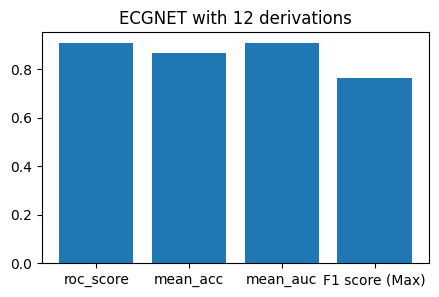

In [468]:
from typing import List
import os
import random
import argparse
import json
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn

# Random seed
seed = 42
random.seed(seed)
np.random.seed(seed)


def epoch_run(
    model: nn.Module, dataset: torch.utils.data.Dataset, device: torch.device
) -> List[np.array]:
    """Testing of the model.
    Parameters
    ----------
    model: nn.Module
        Model to be tested.
    dataset: torch.utils.data.DataLoader
        Dataset to be tested.
    device: torch.device
        Device to be used.
    Returns
    -------
    np.array
        Predicted values.
    """

    model.to(device)
    model.eval()
    pred_all = []

    for batch_step in tqdm(range(len(dataset)), desc="test"):
        batch_x, _ = dataset[batch_step]
        batch_x = batch_x.permute(0, 2, 1).to(device)
        pred = model(batch_x)
        pred_all.append(pred.detach().cpu().numpy())
    pred_all = np.concatenate(pred_all, axis=0)

    return pred_all


def test(
    model: nn.Module,
    #path: str = "data/ptb",
    batch_size: int = 32,
    name: str = "imle_net",
) -> None:
    """Data preprocessing and testing of the model.
    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    path: str, optional
        Path to the directory containing the data. (default: 'data/ptb')
    batch_size: int, optional
        Batch size. (default: 32)
    name: str, optional
        Name of the model. (default: 'imle_net')
    """

    #_, _, X_test_scale, y_test, _, _ = preprocess(path=path)
    test_gen = DataGen(X_test_scale_filt, y_test, batch_size=batch_size)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pred = epoch_run(model, test_gen, device)

    roc_score = roc_auc_score(y_test, pred, average="macro")
    acc, mean_acc = Metrics(y_test, pred)
    class_auc = AUC(y_test, pred)
    summary = metric_summary(y_test, pred)

    print(f"class wise accuracy: {acc}")
    print(f"accuracy: {mean_acc}")
    print(f"roc_score : {roc_score}")
    print(f"class wise AUC : {class_auc}")
    print(f"F1 score (Max): {summary[0]}")
    #print(f"class wise precision, recall, f1 score : {summary}")

    logs = dict()
    logs["roc_score"] = roc_score
    logs["mean_acc"] = mean_acc
    logs["accuracy"] = acc
    logs["class_auc"] = class_auc
    logs["F1 score (Max)"] = summary[0]
    logs["class_precision_recall_f1"] = summary
    logs_path = os.path.join(os.getcwd(), "logs")
    os.makedirs(logs_path, exist_ok=True)

    names =  [ "roc_score" ,"mean_acc" ,"mean_auc" ,"F1 score (Max)"]
    values = [ roc_score , mean_acc , np.mean(class_auc) , summary[0]]

    plt.figure(figsize=(5,3))
    plt.title("ECGNET with 12 derivations")
    plt.bar(range(len(names)), values, tick_label=names)
    plt.show()

    with open(os.path.join(logs_path, f"{name}_test_logs.json"), "w") as json_file:
        json.dump(logs, json_file)



path_weights = os.path.join(os.getcwd(), "checkpoints", "ECGNET_weights.pt")
model = ECGNet()
model.load_state_dict(torch.load(path_weights))

test(model,  batch_size=32, name="ECGNET")  #path=args.data_dir,



In [701]:
mlb.classes_

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)

### TABPFN

In [535]:
label_split = []

for lab in label:
    if lab in NORM:
        label_split.append(0)
    elif lab in STTC:
        label_split.append(1)
    elif lab in MI:
        label_split.append(2)
    elif lab in HYP:
        label_split.append(3)
    elif lab in CD:
        label_split.append(4)
    elif lab in OTHER:
        label_split.append(5)

df_clean_tabpfn = df.loc[patients_idx]
df_clean_tabpfn.insert(0,"label",label_split)

In [542]:
# get 100 patients of each desease
df_NORM = df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == 0].index[0:100]]
df_STTC = df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == 1].index[0:100]]
df_MI = df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == 2].index[0:100]]
df_HYP = df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == 3].index[0:100]]
df_CD = df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == 4].index[0:100]]

In [544]:
# make one csv
names_lab = [ "df_STTC" ,"df_MI" ,"df_HYP" ,"df_CD"]
df_concat = df_NORM
for i in range(4):
    i = i+1
    df_concat = df_concat.append(df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == i].index[0:100]])

df_concat


C:\Users\maria\AppData\Local\Temp\ipykernel_19716\1860732234.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_concat = df_concat.append(df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == i].index[0:100]])
C:\Users\maria\AppData\Local\Temp\ipykernel_19716\1860732234.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_concat = df_concat.append(df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == i].index[0:100]])
C:\Users\maria\AppData\Local\Temp\ipykernel_19716\1860732234.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_concat = df_concat.append(df_clean_tabpfn.loc[df_clean_tabpfn[df_clean_tabpfn.label == i].index[0:100]])
C:\Users\maria\AppData\Local\Temp\ipykernel_19716\1860732234.py:5: Fut

,label,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,...,SLI-LVH,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL
15709,0,15745,4747.0,54.0,0,177.0,93.0,3.0,1.0,AT-6 C 5.5,...,False,False,False,False,False,False,False,False,False,False
13243,0,13273,15517.0,40.0,1,NaN,NaN,1.0,2.0,CS-12,...,False,False,False,True,False,False,False,False,False,True
20372,0,20409,15989.0,71.0,1,NaN,NaN,0.0,0.0,CS100 3,...,False,False,False,True,False,False,False,False,False,True
17014,0,17050,20518.0,86.0,1,NaN,NaN,1.0,2.0,CS-12,...,False,False,False,True,False,False,False,False,False,True
17448,0,17484,9809.0,55.0,0,NaN,NaN,0.0,0.0,CS100 3,...,False,False,False,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15158,4,15193,16147.0,58.0,0,NaN,NaN,0.0,0.0,CS100 3,...,False,False,False,False,True,False,False,True,False,True
15158,4,15193,16147.0,58.0,0,NaN,NaN,0.0,0.0,CS100 3,...,False,False,False,False,True,False,False,True,False,True
10756,4,10782,7935.0,87.0,1,158.0,49.0,NaN,33.0,AT-6 C 5.5,...,True,False,False,True,True,False,True,False,False,True
8997,4,9020,6487.0,66.0,0,168.0,74.0,1.0,1.0,AT-6 C 5.6,...,False,False,False,False,True,True,False,False,False,True


In [545]:
# get signals
path = os.path.join(os.getcwd(), Path(path))
data_tabpfn = np.array([wfdb.rdsamp(os.path.join(path, f))[0] for f in df_concat.filename_lr])

In [548]:
len(df_concat),len(data_tabpfn)

(626, 626)

In [552]:
# extract info about beats

dict_patients = {}
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import pywt
from scipy.signal import butter, lfilter, freqz
from scipy.signal import welch
from scipy.integrate import simps
from mne.time_frequency import psd_array_multitaper

fs = 100
data = pd.DataFrame() 
for i,index in enumerate(tqdm(df_concat.index.values)):
    derivations = data_tabpfn[i].T
    #print(derivations)
    derivations_to_append = np.ndarray(shape=(1000,12))
     # columns = columns
    label = df_clean_tabpfn.label.values[i]
    try:

        for j,signal in enumerate(derivations):
            s = filter_signal(signal,[5,30],100,2,"bandpass")
            qrs = find_qrs(s,signal_labels[j], len(signal))
            t = np.arange(0,len(s)/fs, 1/fs)
            #rr = np.diff(self.t[qrs])

            # get channel
            channel = signal_labels[j]
            
            beats = qrs

            rr = np.diff(t[qrs])

            # RMSSD: take the square root of the mean square of the differences
            rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
            # Mean RR
            mean_rr = np.mean(rr)
            # SDNN
            sdnn = np.std(rr)
            # Mean HR
            mean_hr = 60 * 1000/np.mean(rr)
            # STD HR
            std_hr = np.std(rr)
            # Min HR
            min_hr = np.min(rr)
            # Max HR
            max_hr = np.max(rr)
            # NNxx: sum absolute differences that are larger than 50ms
            nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
            # pNNx: fraction of nnxx of all rr-intervals
            pnnx = 100 * nnxx / len(rr)

            dict_patients["Patient"] = df_concat.patient_id.values[i]
            dict_patients["rmssd"] = rmssd
            dict_patients["mean_rr"] = mean_rr
            dict_patients["sdnn"] = sdnn
            dict_patients["mean_hr"] = mean_hr
            dict_patients["std_hr"] = std_hr
            dict_patients["min_hr"] = min_hr
            dict_patients["max_hr"] = max_hr
            dict_patients["nnxx"] = nnxx
            dict_patients["pnnx"] = pnnx       
            #label
            dict_patients["label"] = label     


            rp_0_20 = 0
            rp_20_50 = 0
            ratio_low_high = 0
            max_wPSD = 0
            min_wPSD = 0
            max_coef_wPSD = 0
            min_coef_wPSD = 0
            mean_spec_phase = 0
            max_max_phase_spec = 0
            mean_max_phase_spec = 0
            mean_max_modulus_spec = 0
            mean_max_spectgram=0
            for n,value in enumerate(qrs[1:-1]):
                segment = s[value-35:value+45]

                #potencias en banda y ratios 
                rp_0_20 += round(bandpower(segment,fs,[5.5,20],method = 'multitaper'),3)
                rp_20_50 += round(bandpower(segment,fs,[20,30],method = 'multitaper'),3)
                ratio_low_high +=  rp_0_20 / rp_20_50

                # get wPSD
                wavelet = "gaus3"
                coef, freqs = pywt.cwt(segment, wavelet = wavelet, scales =np.arange(1,129))
                max_wPSD+= np.max(coef)
                min_wPSD += np.min(coef)
                max_coef_wPSD += np.where(coef == np.max(coef))[0][0]
                min_coef_wPSD += np.where(coef == np.min(coef))[0][0]

                # get mean of maximums of spectgram
                nperseg = fs/2
                ftf, ftt, ftZ = ss.stft(segment , nperseg= nperseg, fs=fs)  # es ftZ
                max_spec = [max(i) for i in ftZ]
                mean_max_spectgram += np.mean(max_spec)

                # phase y modulo de la media general del espectrograma
                mean_spec_phase, mean_spec_modulus = np.angle(np.mean(ftZ)), np.abs(np.mean(ftZ))

                # phase maxima de los maximos, y phase y modulo de la media de los maximos del espectrograma
                max_spec = [max(i) for i in ftZ]
                mean_max_spectgram += np.mean(max_spec)
                max_max_phase_spec += max(np.angle(max_spec))
                mean_max_phase_spec += np.angle(mean_max_spectgram)
                mean_max_modulus_spec += np.abs(mean_max_spectgram)

            rp_0_20 /= len(beats)
            rp_20_50 /= len(beats)
            ratio_low_high /= len(beats)
            max_wPSD /= len(beats)
            min_wPSD /= len(beats)
            max_coef_wPSD /= len(beats)
            min_coef_wPSD /= len(beats)
            mean_spec_phase /= len(beats)
            max_max_phase_spec /= len(beats)
            mean_max_phase_spec /= len(beats)
            mean_max_modulus_spec /= len(beats)
                # get info in to the dict
                
            dict_patients[f"{channel}_Channel"] = channel
            dict_patients[f"{channel}_rp_0_20"] = rp_0_20
            dict_patients[f"{channel}_rp_20_50"] = rp_20_50
            dict_patients[f"{channel}_ratio_low_high"] = ratio_low_high
                
                    # wPSD
            dict_patients[f"{channel}_max_wPSD"] = max_wPSD
            dict_patients[f"{channel}_min_wPSD"] = min_wPSD
            dict_patients[f"{channel}_max_coef_wPSD"] = max_coef_wPSD
            dict_patients[f"{channel}_min_coef_wPSD"] = min_coef_wPSD
                    # spect
            dict_patients[f"{channel}_mean_spec_phase"] = mean_spec_phase 
            dict_patients[f"{channel}_max_max_phase_spec"] = max_max_phase_spec
            dict_patients[f"{channel}_mean_max_phase_spec"] = mean_max_phase_spec
            dict_patients[f"{channel}_mean_max_modulus_spec"] = mean_max_modulus_spec
                # time amplitude features
            dict_patients[f"{channel}_max_ampl"] = min(segment)
            dict_patients[f"{channel}_min_ampl"] = max(segment)
                

                # append in dataframe
        data = data.append(dict_patients, ignore_index=True)
        #data = data.merge(df_concat,on="Patient")

        data.to_csv(f"D:\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2 (1)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2\{df_concat.patient_id.values[i]}.csv")
        data
    except Exception:
        print(df_concat.patient_id.values[i])
        pass

  6%|▌         | 35/626 [02:18<29:35,  3.00s/it]

16373.0


100%|██████████| 626/626 [46:43<00:00,  4.48s/it]


In [ ]:
data.rename(columns={"Patient": "patient_id"},inplace=True)

In [655]:
data_merged =df_concat.merge(data,on="patient_id",)
data_merged

,label_x,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,...,V6_min_wPSD,V6_max_coef_wPSD,V6_min_coef_wPSD,V6_mean_spec_phase,V6_max_max_phase_spec,V6_mean_max_phase_spec,V6_mean_max_modulus_spec,V6_max_ampl,V6_min_ampl,split
0,0,15745,4747.0,54.0,0,177.0,93.0,3.0,1.0,AT-6 C 5.5,...,-0.901253,2.125000,1.500000,-0.386118,1.925034,0.181378,0.056626,-0.357721,0.965423,train
1,0,13273,15517.0,40.0,1,NaN,NaN,1.0,2.0,CS-12,...,-0.818945,2.384615,2.000000,0.001119,1.428317,0.343883,0.084052,-0.352679,0.774206,train
2,0,20409,15989.0,71.0,1,NaN,NaN,0.0,0.0,CS100 3,...,-1.794264,2.272727,2.181818,-0.002837,1.342843,0.279454,0.151219,-0.754396,1.537340,train
3,0,17050,20518.0,86.0,1,NaN,NaN,1.0,2.0,CS-12,...,-0.658359,1.615385,1.615385,0.013928,1.258211,-0.052984,0.086243,-0.287107,0.641487,train
4,0,17484,9809.0,55.0,0,NaN,NaN,0.0,0.0,CS100 3,...,-0.537296,1.714286,1.714286,0.181698,1.438793,0.359161,0.060447,-0.284345,0.429590,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094,4,15193,16147.0,58.0,0,NaN,NaN,0.0,0.0,CS100 3,...,-0.301092,1.600000,1.600000,-0.309996,1.430461,0.017662,0.034499,-0.225003,0.292541,train
2095,4,15193,16147.0,58.0,0,NaN,NaN,0.0,0.0,CS100 3,...,-0.301092,1.600000,1.600000,-0.309996,1.430461,0.017662,0.034499,-0.225003,0.292541,train
2096,4,10782,7935.0,87.0,1,158.0,49.0,NaN,33.0,AT-6 C 5.5,...,-0.759200,2.100000,2.100000,-0.309893,1.913356,0.248247,0.059261,-0.248321,0.710151,train
2097,4,9020,6487.0,66.0,0,168.0,74.0,1.0,1.0,AT-6 C 5.6,...,-0.360205,1.076923,1.538462,-0.236088,1.398380,-0.187229,0.037502,-0.207222,0.336683,test


In [656]:
data_merged = data_merged[['patient_id',
 'label_x',
 'I_rp_0_20',
 'I_rp_20_50',
 'I_ratio_low_high',
 'I_max_wPSD',
 'I_min_wPSD',
 'I_max_coef_wPSD',
 'I_min_coef_wPSD',
 'I_mean_spec_phase',
 'I_max_max_phase_spec',
 'I_mean_max_phase_spec',
 'I_mean_max_modulus_spec',
 'I_max_ampl',
 'I_min_ampl',
 'II_rp_0_20',
 'II_rp_20_50',
 'II_ratio_low_high',
 'II_max_wPSD',
 'II_min_wPSD',
 'II_max_coef_wPSD',
 'II_min_coef_wPSD',
 'II_mean_spec_phase',
 'II_max_max_phase_spec',
 'II_mean_max_phase_spec',
 'II_mean_max_modulus_spec',
 'II_max_ampl',
 'II_min_ampl',
 'III_rp_0_20',
 'III_rp_20_50',
 'III_ratio_low_high',
 'III_max_wPSD',
 'III_min_wPSD',
 'III_max_coef_wPSD',
 'III_min_coef_wPSD',
 'III_mean_spec_phase',
 'III_max_max_phase_spec',
 'III_mean_max_phase_spec',
 'III_mean_max_modulus_spec',
 'III_max_ampl',
 'III_min_ampl',
 'AVR_rp_0_20',
 'AVR_rp_20_50',
 'AVR_ratio_low_high',
 'AVR_max_wPSD',
 'AVR_min_wPSD',
 'AVR_max_coef_wPSD',
 'AVR_min_coef_wPSD',
 'AVR_mean_spec_phase',
 'AVR_max_max_phase_spec',
 'AVR_mean_max_phase_spec',
 'AVR_mean_max_modulus_spec',
 'AVR_max_ampl',
 'AVR_min_ampl',
 'AVL_rp_0_20',
 'AVL_rp_20_50',
 'AVL_ratio_low_high',
 'AVL_max_wPSD',
 'AVL_min_wPSD',
 'AVL_max_coef_wPSD',
 'AVL_min_coef_wPSD',
 'AVL_mean_spec_phase',
 'AVL_max_max_phase_spec',
 'AVL_mean_max_phase_spec',
 'AVL_mean_max_modulus_spec',
 'AVL_max_ampl',
 'AVL_min_ampl',
 'AVF_rp_0_20',
 'AVF_rp_20_50',
 'AVF_ratio_low_high',
 'AVF_max_wPSD',
 'AVF_min_wPSD',
 'AVF_max_coef_wPSD',
 'AVF_min_coef_wPSD',
 'AVF_max_ampl',
 'AVF_min_ampl', 
 "age", "sex", "height", "weight",
    'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
        'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
        'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL']]

In [657]:
Counter(data_merged.label_x.values)

Counter({0: 293, 4: 470, 1: 496, 5: 362, 3: 151, 2: 327})

In [688]:
from sklearn.model_selection import train_test_split
X = data_merged.drop(["patient_id","label_x","split"],axis=1)   #[data_merged.split =="train"].drop(["patient_id","label_x","split"],axis=1)
y = data_merged.label_x  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((1049, 93), (1049,), (1050, 93), (1050,))

In [689]:
y_train.value_counts(),y_test.value_counts()

(1    248
 4    235
 5    181
 2    163
 0    146
 3     76
 Name: label_x, dtype: int64,
 1    248
 4    235
 5    181
 2    164
 0    147
 3     75
 Name: label_x, dtype: int64)

In [690]:
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=3)

classifier.fit(X_train, y_train,overwrite_warning=True)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier()

In [691]:
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Accuracy 0.6152380952380953


In [693]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_eval, target_names=["0","1","2","3","4","5"]))

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       147
           1       0.46      0.27      0.34       248
           2       0.66      0.51      0.58       164
           3       0.20      0.04      0.07        75
           4       0.66      0.80      0.72       235
           5       0.63      0.99      0.77       181

    accuracy                           0.62      1050
   macro avg       0.54      0.58      0.54      1050
weighted avg       0.57      0.62      0.57      1050



# INTERFACE

In [3]:
import sys
from PySide6 import QtWidgets, QtCore
import pyqtgraph as pg
from scipy.fftpack import fft,fftfreq
import json
#from ui_app_eeg import Ui_MainWindow
from ui_window_ecg import Ui_MainWindow
import pyqtgraph as pg
from PySide6.QtWidgets import QTableWidgetItem,QGraphicsView, QPlainTextEdit, QApplication, QMainWindow, QComboBox , QLabel, QCheckBox, QMessageBox, QRadioButton, QListWidget, QLineEdit , QFileDialog
from PySide6.QtCore import Qt
from pathlib import Path
import pyqtgraph.exporters
import jinja2
import pdfkit
import os
#para acceder al editor de la app: copiar en "buscar" este enlace C:\Users\David\AppData\Local\Programs\Python\Python39\Lib\site-packages\PySide6
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def absPath(file):
    # Devuelve la ruta absoluta a un fichero desde el propio script
    return str(Path(__file__).parent.absolute() / file)

class MainWindow(QMainWindow,Ui_MainWindow):

    #MODO NORMAL
    def __init__(self):
        super().__init__()
        
        self.setupUi(self)

        self.grafica_eeg.setBackground("w")
        self.grafica_eeg.showGrid(x=True,y=True)

        self.grafica_qrs.setBackground("w")
        self.grafica_qrs.showGrid(x=True,y=True)

        self.grafica_qrs_mean.setBackground("w")
        self.grafica_qrs_mean.showGrid(x=True,y=True)

        self.actionCargar_edf.triggered.connect(self.open)
        self.plot1.clicked.connect(self.plot_signal)
        self.plot2.clicked.connect(self.plot_signal_2)
        self.Limpiar_signals.clicked.connect(self.clean_signal)

        self.plot_qrs.clicked.connect(self.plot_qrs_)
        self.plot_qrs_mean.clicked.connect(self.plt_qrs_mean)

        self.pushButton_left.clicked.connect(self.plot_qrs_left)
        self.pushButton_right.clicked.connect(self.plot_qrs_right)

        self.show_parameters.clicked.connect(self.compute_vars)


    def open(self):

        try:
            archivo = QFileDialog.getOpenFileName(self,"Open file","C:\\")
            self.archivo = str(os.path.basename(os.path.normpath(archivo[0]))) #archivo[0].split("/")[-1].split(".")[0]
            #self.file_name = absPath(archivo[0])  # str(os.path.basename(os.path.normpath(archivo[0])))

            path = os.path.join(os.getcwd(), Path("D:\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2 (1)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2"))
            self.Y = pd.read_csv(os.path.join(path ,"ptbxl_database.csv"), index_col="ecg_id")
            index = np.where(self.Y.filename_lr.values ==[x for x in self.Y.filename_lr.values if x.split("/")[-1] == self.archivo.split(".")[0]][0])[0][0]
            print(index)
            self.info = wfdb.rdsamp(os.path.join(path,  self.Y.filename_lr.values[index]))#[1]['sig_name']
            #print(self.Y.filename_lr.values[0])
            #self.info = wfdb.rdsamp(os.path.join(path, f"{archivo}"))#[1]['sig_name']
            self.fs = self.info[1]['fs']
            self.ecg = self.info[0].T
            self.t = np.arange(0,self.ecg.shape[1]/self.fs, 1/self.fs)

            # cogemos sus nombres con .ch_names
            self.signal_labels = self.info[1]["sig_name"]   #['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
            self.desplegable.addItems(self.signal_labels) 
            self.desplegable_2.addItems(self.signal_labels) 
            self.desplegable_3.addItems(self.signal_labels) 

            #para seleccionar la señal
        #    self.desplegable.clear()
        #    self.desplegable.addItems(self.signal_labels)   
        
        except NotImplementedError:
            QtWidgets.QMessageBox.critical(self, "Ups.", f"Error leyendo el archivo")


    def plot_signal(self):
       
        self.pos = 1
        self.grafica_eeg.clear()
        low = int(self.button_hours_low.text())*3600  +  int(self.button_minutes_low.text())*60  +  int(self.button_seconds_low.text())
        low = np.where(self.t == low)
        self.low = low[0][0]

        high = int(self.button_hours_high.text())*3600  +  int(self.button_minutes_high.text())*60  +  int(self.button_seconds_high.text()) 
        high = np.where(self.t == high)
        self.high = high[0][0]
        
        self.grafica_eeg.clear()
        self.patient = self.archivo.split(".")[0]
        self.grafica_eeg.setTitle(f"{self.patient}", size = "20px")

        try:
            nPlots = 6 #len(self.ecg)
            curves = []
            for idx in np.arange(0,nPlots,1): #self.signal_labels[0:6]:
                #x = self.signal_labels.index(idx)

                ecg = self.ecg[idx,:]
                ecg_bp = filter_signal(ecg,[5,30],self.fs,order = 2, filtertype='bandpass')
                self.ecg_notch = filter_signal(ecg_bp,50,self.fs,order = 4, filtertype='notch')

                self.grafica_eeg.plot(self.t[self.low:self.high],self.ecg_notch[self.low:self.high] -idx*6,pen= pg.mkPen(f"#00{idx}",width = 2), name= f"{self.signal_labels[idx]}")
                    
                #ax1.plot(t, ecg_notch)
                self.qrs = find_qrs(self.ecg_notch[self.low:self.high],self.signal_labels[idx], self.high)
                #self.grafica_eeg.plot(self.t[self.low:self.high][self.qrs],self.ecg_notch[self.low:self.high][self.qrs]-idx*6,symbol="o",symbolSize=5)
                #ax1.set_ylabel(f'{signal}', **yprops)


                styles = {"color":"#000", "font-size":"13px"}
                self.grafica_eeg.setLabel("left",'Amplitude [mV]',**styles)
                self.grafica_eeg.setLabel("bottom",'time [s]',**styles)
                self.grafica_eeg.addLegend()
        except Exception:
                pass
   

    def plot_signal_2(self):
        
        self.pos = 1
        self.grafica_eeg.clear()
        low = int(self.button_hours_low.text())*3600  +  int(self.button_minutes_low.text())*60  +  int(self.button_seconds_low.text())
        low = np.where(self.t == low)
        self.low = low[0][0]

        high = int(self.button_hours_high.text())*3600  +  int(self.button_minutes_high.text())*60  +  int(self.button_seconds_high.text()) 
        high = np.where(self.t == high)
        self.high = high[0][0]
        
        self.grafica_eeg.clear()
        self.patient = self.archivo.split(".")[0]
        self.grafica_eeg.setTitle(f"{self.patient}", size = "20px")
        
        #ecg = self.ecg[11,:]
        #ecg_bp = filter_signal(ecg,[0.6,40],self.fs,order = 4, filtertype='bandpass')
        #self.ecg_notch = filter_signal(ecg_bp,50,self.fs,order = 4, filtertype='notch')
        #qrs = find_qrs(self.ecg_notch[self.low:self.high],self.signal_labels[11], self.high)
        #hr = np.diff(self.t[qrs])
        #self.grafica_eeg.plot(self.t[self.low:self.high],hr[self.low:self.high],pen= pg.mkPen("red",width = 2), name= "Heart Rate")
        try:
                nPlots = 6 #len(self.ecg)
                curves = []
                for idx in np.arange(0,nPlots,1):
                    idx += 1
                    #x = self.signal_labels.index(idx)

                    ecg = self.ecg[idx+6,:]
                    ecg_bp = filter_signal(ecg,[5,30],self.fs,order = 2, filtertype='bandpass')
                    self.ecg_notch = filter_signal(ecg_bp,50,self.fs,order = 4, filtertype='notch')


                    self.grafica_eeg.plot(self.t[self.low:self.high],self.ecg_notch[self.low:self.high] -idx*6,pen= pg.mkPen(f"#00{idx}",width = 2), name= f"{self.signal_labels[idx+6]}")
                
                    #ax1.plot(t, ecg_notch)
                    self.qrs = find_qrs(self.ecg_notch[self.low:self.high],self.signal_labels[idx], self.high)
                    #self.grafica_eeg.plot(self.t[self.low:self.high][self.qrs],self.ecg_notch[self.low:self.high][self.qrs]-idx*6,symbol="o",symbolSize=5)
                    #ax1.set_ylabel(f'{signal}', **yprops)


                    styles = {"color":"#000", "font-size":"13px"}
                    self.grafica_eeg.setLabel("left",'Amplitude [mV]',**styles)
                    self.grafica_eeg.setLabel("bottom",'time [s]',**styles)
                    self.grafica_eeg.addLegend()
        except Exception:
                pass


    def clean_signal(self):
        self.titulo_plot = []
        self.grafica_eeg.clear()
        self.textEdit.clear()
        self.desplegable.clear()
        self.grafica_qrs_mean.clear()
        self.grafica_qrs.clear()


    def plot_qrs_(self):
        # nos quedamos con el valor del nombre de la señal que hay en el desplegable
        self.s = self.desplegable.currentText()
        self.x = self.signal_labels.index(self.s)

        #self.desplegable.addItems(self.signal_labels)   
        
    
    def plt_qrs_mean(self):
        self.grafica_qrs_mean.clear()

        # nos quedamos con el valor del nombre de la señal que hay en el desplegable
        self.s = self.desplegable_2.currentText()
        self.x = self.signal_labels.index(self.s)

        ecg = self.ecg[self.x,:]
        ecg_bp = filter_signal(ecg,[5,30],self.fs,order = 2, filtertype='bandpass')
        ecg_notch = filter_signal(ecg_bp,50,self.fs,order = 4, filtertype='notch')

        self.qrs = find_qrs(ecg_notch[self.low:self.high],self.signal_labels[0], self.high)

        complex = np.ones(74)*0

        for beat in self.qrs[1:-1]:
            complex += np.array(ecg_notch[self.low:self.high][beat-30:beat+44])
        complex /= len(self.qrs[1:-1])
        self.grafica_qrs_mean.plot(complex,pen= pg.mkPen(f"#000",width = 3))


    def plot_qrs_left(self):
        try:
            self.grafica_eeg.removeItem(self.rgn)
        except Exception:
            pass
        try:
            self.pos -= 1
            self.grafica_qrs.clear()

            # nos quedamos con el valor del nombre de la señal que hay en el desplegable
            self.s = self.desplegable.currentText()
            self.x = self.signal_labels.index(self.s)

            ecg = self.ecg[self.x,:]
            ecg_bp = filter_signal(ecg,[5,30],self.fs,order = 2, filtertype='bandpass')
            ecg_notch = filter_signal(ecg_bp,50,self.fs,order = 4, filtertype='notch')

            qrs = find_qrs(ecg_notch[self.low:self.high],self.signal_labels[0], self.high)

            beat = qrs[self.pos]
            complex = np.array(ecg_notch[self.low:self.high][beat-40:beat+74])
            self.grafica_qrs.plot(complex,pen= pg.mkPen(f"#000",width = 3),name = f"Beat at second {self.t[beat]}")

            left = self.t[beat-30] #np.where(self.t == beat-30)[0][0]
            right = self.t[beat+44]
            self.rgn = pg.LinearRegionItem([left, right])  #donde colocarlo en eje x y eje y
            self.grafica_eeg.addItem(self.rgn)
            self.grafica_qrs.setTitle(f"Beat at second {self.t[beat]}")

           # vertical_line1 = pg.InfiniteLine(pos = self.art_low , angle=90, movable=True,  hoverPen= "black" ) 

           # vertical_line1.addMarker ( marker ="o" ,  size = 13.0)

           # self.grafica_eeg.addItem(vertical_line1)
            
        except Exception:
            pass


    def plot_qrs_right (self):
        try:
            self.grafica_eeg.removeItem(self.rgn)
        except Exception:
            pass
        try:
            
            self.pos += 1
            self.grafica_qrs.clear()

            # nos quedamos con el valor del nombre de la señal que hay en el desplegable
            self.s = self.desplegable.currentText()
            self.x = self.signal_labels.index(self.s)

            ecg = self.ecg[self.x,:]
            ecg_bp = filter_signal(ecg,[5,30],self.fs,order = 2, filtertype='bandpass')
            ecg_notch = filter_signal(ecg_bp,50,self.fs,order = 4, filtertype='notch')

            qrs = find_qrs(ecg_notch[self.low:self.high],self.signal_labels[0], self.high)

            beat = qrs[self.pos]
            complex = np.array(ecg_notch[self.low:self.high][beat-40:beat+74])
            self.grafica_qrs.plot(complex,pen= pg.mkPen(f"#000",width = 3),name = f"Beat at second {self.t[beat]}")

            left = self.t[beat-30] #np.where(self.t == beat-30)[0][0]
            right = self.t[beat+44] #np.where(self.t == beat+44)[0][0]
            self.rgn = pg.LinearRegionItem([left, right])  #donde colocarlo en eje x y eje y
            
            
            self.grafica_qrs.setTitle(f"Beat at second {self.t[beat]}")
       
            self.grafica_eeg.addItem(self.rgn)
            
        except Exception:
            pass

    def compute_vars(self):
            self.tableWidget.clear()

            
            # nos quedamos con el valor del nombre de la señal que hay en el desplegable
            self.s = self.desplegable_3.currentText()
            self.x = self.signal_labels.index(self.s)

            ecg = self.ecg[self.x,:]
            ecg_bp = filter_signal(ecg,[5,30],self.fs,order = 2, filtertype='bandpass')
            ecg_notch = filter_signal(ecg_bp,50,self.fs,order = 4, filtertype='notch')

            # para que no se pueda modificar los datos de la tabla
            self.tableWidget.setEditTriggers(QtWidgets.QAbstractItemView.NoEditTriggers)


            styles = {"color":"#000", "font-size":"13px"}
            
            #potencias en banda y ratios 
            rp_0_20 = round(bandpower(ecg_notch[self.low:self.high],self.fs,[0.5,20]),3)
            rp_20_50 = round(bandpower(ecg_notch[self.low:self.high],self.fs,[20,50]),3)
            ratio_low_high =  rp_0_20 / rp_20_50

            qrs = find_qrs(ecg_notch[self.low:self.high],self.signal_labels[0], self.high)
            rr = np.diff(self.t[qrs])

            # RMSSD: take the square root of the mean square of the differences
            rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
            # Mean RR
            mean_rr = np.mean(rr)
            # SDNN
            sdnn = np.std(rr)
            # Mean HR
            mean_hr = 60 * 1000/np.mean(rr)
            # STD HR
            std_hr = np.std(rr)
            # Min HR
            min_hr = np.min(rr)
            # Max HR
            max_hr = np.max(rr)
            # NNxx: sum absolute differences that are larger than 50ms
            nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
            # pNNx: fraction of nnxx of all rr-intervals
            pnnx = 100 * nnxx / len(rr)

            self.nombres_filas = ["rp_0_20", "rp_20_50",
                "rmssd","mean_rr","sdnn","mean_hr", "std_hr" ,"min_hr" ,"max_hr" ,"nnxx" ,"pnnx"]

            # Creamos la estructura de datosX
            datos = []

            # Añadimos un registro manualmente
            datos.append({
                f"{self.patient}": rp_0_20,
            })

            # Definimos una lista de contactos
            contactos = [
                (rp_20_50),
                (rmssd),
                (mean_rr),
                (sdnn),
                (mean_hr),
                (std_hr),
                (min_hr),
                (max_hr),
                (nnxx),
                (pnnx)
            ]

            # Añadimos un contacto dinámicamente
            for valor in contactos:
                datos.append({
                    f"{self.patient}": valor
                })

            # Guardamos los registros del fichero
           # with open(absPath("contactos.json"), "w") as fichero:
           #     json.dump(datos, fichero)

            # Leemos los registros del fichero
           # with open(absPath("contactos.json")) as fichero:
           #    datos = json.load(fichero)
                

            # cargamos el contenido del fichero
            #with open(absPath("contactos.json")) as fichero:
                #self.datos = json.load(fichero)

            self.datos = datos

            # definimos la configuración de las columnas (claves del json)
            self.columnas = [f"{self.patient}"]

            # configuramos la tabla a partir de la información recuperada
            self.tableWidget.setRowCount(len(self.datos))
            # establecemos la longitud de las columnas
            self.tableWidget.setColumnCount(len(self.columnas))
            # establecemos las cabeceras de las columnas
            self.tableWidget.setHorizontalHeaderLabels(self.columnas)

            # dibujamos la tabla y los botones
            for i,value in enumerate(self.datos):
                print(list(value.values())[0])
                #for j, columna in enumerate(self.columnas):
                item = QTableWidgetItem()
                # Con Qt.EditRole se establece el tipo de campo automáticamente
                item.setData(Qt.EditRole, list(value.values())[0] )#fila[columna])
                self.tableWidget.setItem(i, 0, item)

            # personalizamos y redimensionamos la tabla
            #self.tableWidget.setHorizontalHeaderItem(0, QTableWidgetItem(f"Signal {self.titulo_plot[0]}"))
            #self.tableWidget.setHorizontalHeaderItem(1, QTableWidgetItem(f"Signal {self.titulo_plot[1]}"))
            self.tableWidget.setVerticalHeaderItem(0, QTableWidgetItem(self.nombres_filas[0]))
            self.tableWidget.setVerticalHeaderItem(1, QTableWidgetItem(self.nombres_filas[1]))
            self.tableWidget.setVerticalHeaderItem(2, QTableWidgetItem(self.nombres_filas[2]))
            self.tableWidget.setVerticalHeaderItem(3, QTableWidgetItem(self.nombres_filas[3]))
            self.tableWidget.setVerticalHeaderItem(4, QTableWidgetItem(self.nombres_filas[4]))
            self.tableWidget.setVerticalHeaderItem(5, QTableWidgetItem(self.nombres_filas[5]))
            self.tableWidget.setVerticalHeaderItem(6, QTableWidgetItem(self.nombres_filas[6]))
            self.tableWidget.setVerticalHeaderItem(7, QTableWidgetItem(self.nombres_filas[7]))
            self.tableWidget.setVerticalHeaderItem(8, QTableWidgetItem(self.nombres_filas[8]))
            self.tableWidget.setVerticalHeaderItem(9, QTableWidgetItem(self.nombres_filas[9]))
            self.tableWidget.setVerticalHeaderItem(10, QTableWidgetItem(self.nombres_filas[10]))




In [6]:
if not QtWidgets.QApplication.instance():
    app = QtWidgets.QApplication(sys.argv)
else:
    app = QtWidgets.QApplication.instance()

if __name__ == "__main__":
    window = MainWindow()
    window.show()
    sys.exit(app.exec_())


C:\Users\maria\AppData\Local\Temp\ipykernel_19076\446205115.py:9: DeprecationWarning: 'exec_' will be removed in the future. Use 'exec' instead.
  sys.exit(app.exec_())


IndexError: list index out of range

16979
0.004
0.001
0.011094003924504053
0.6064285714285713
0.007178482586514652
98939.92932862193
0.007178482586514652
0.5900000000000001
0.6199999999999992
0
0.0
